In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


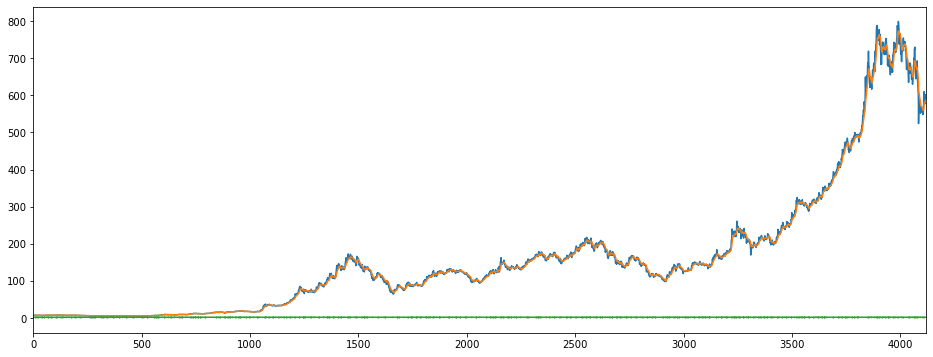

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2001-09-14,7.142585,7.257483,-41.873824,204624213.0,2.0
2001-09-17,7.224180,7.252359,-51.296847,208479649.0,2.0
2001-09-18,7.132634,7.233940,-72.964156,203965392.0,2.0
2001-09-19,7.214230,7.230908,-59.609037,209378730.0,2.0
2001-09-20,7.347568,7.248855,-37.785092,213725440.0,2.0


In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4101, 20, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4101, 20, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4101, 20, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4101, 20, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4101, 64, 64, 1)

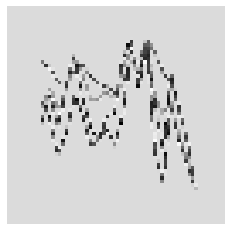

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.387387387387387, 1: 7.488584474885845, 2: 0.3661531591873186}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.3521 - accuracy: 0.7109 - mse: 5.5409 - weighted_accuracy: 0.4630 - weighted_mse: 5.5715WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 26ms/step - loss: 0.2509 - accuracy: 0.3119 - mse: 1.7319 - weighted_accuracy: 0.3107 - weighted_mse: 1.7596 - val_loss: 0.2027 - val_accuracy: 0.0451 - val_mse: 0.8980 - val_weighted_accuracy: 0.0451 - val_weighted_mse: 0.8980
Epoch 2/200
26/26 [==============================] - 0s 10ms/step - loss: 0.2043 - accuracy: 0.1985 - mse: 1.1885 - weighted_accuracy: 0.3557 - weighted_mse: 1.1940 - val_loss: 0.2005 - val_accuracy: 0.0475 - va

Epoch 27/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2003 - accuracy: 0.2674 - mse: 1.1717 - weighted_accuracy: 0.3244 - weighted_mse: 1.1716 - val_loss: 0.2010 - val_accuracy: 0.0487 - val_mse: 0.9492 - val_weighted_accuracy: 0.0487 - val_weighted_mse: 0.9492
Epoch 28/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1982 - accuracy: 0.2957 - mse: 1.1851 - weighted_accuracy: 0.3822 - weighted_mse: 1.1744 - val_loss: 0.2036 - val_accuracy: 0.0609 - val_mse: 1.0602 - val_weighted_accuracy: 0.0609 - val_weighted_mse: 1.0602
Epoch 29/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2005 - accuracy: 0.3134 - mse: 1.1726 - weighted_accuracy: 0.3176 - weighted_mse: 1.1657 - val_loss: 0.2020 - val_accuracy: 0.0633 - val_mse: 0.9531 - val_weighted_accuracy: 0.0633 - val_weighted_mse: 0.9531
Epoch 30/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1998 - accuracy: 0.2878 - mse: 1.1725 - weighted_accuracy: 0.3732 - weig

Epoch 84/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1731 - accuracy: 0.1314 - mse: 1.2973 - weighted_accuracy: 0.5095 - weighted_mse: 1.2700 - val_loss: 0.1966 - val_accuracy: 0.1011 - val_mse: 1.1375 - val_weighted_accuracy: 0.1011 - val_weighted_mse: 1.1375
Epoch 85/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1703 - accuracy: 0.1451 - mse: 1.3147 - weighted_accuracy: 0.5577 - weighted_mse: 1.2779 - val_loss: 0.1981 - val_accuracy: 0.1108 - val_mse: 1.0536 - val_weighted_accuracy: 0.1108 - val_weighted_mse: 1.0536
Epoch 86/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1731 - accuracy: 0.1418 - mse: 1.2867 - weighted_accuracy: 0.5369 - weighted_mse: 1.2431 - val_loss: 0.1987 - val_accuracy: 0.0999 - val_mse: 1.0819 - val_weighted_accuracy: 0.0999 - val_weighted_mse: 1.0819
Epoch 87/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1686 - accuracy: 0.1546 - mse: 1.3439 - weighted_accuracy: 0.5485 - weig

Epoch 113/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1562 - accuracy: 0.2012 - mse: 1.4577 - weighted_accuracy: 0.5890 - weighted_mse: 1.4531 - val_loss: 0.1946 - val_accuracy: 0.2448 - val_mse: 1.1561 - val_weighted_accuracy: 0.2448 - val_weighted_mse: 1.1561
Epoch 114/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1547 - accuracy: 0.2009 - mse: 1.4419 - weighted_accuracy: 0.6104 - weighted_mse: 1.4437 - val_loss: 0.1925 - val_accuracy: 0.2692 - val_mse: 1.2372 - val_weighted_accuracy: 0.2692 - val_weighted_mse: 1.2372
Epoch 115/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1531 - accuracy: 0.2159 - mse: 1.4718 - weighted_accuracy: 0.6247 - weighted_mse: 1.4705 - val_loss: 0.1902 - val_accuracy: 0.3021 - val_mse: 1.2533 - val_weighted_accuracy: 0.3021 - val_weighted_mse: 1.2533
Epoch 116/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1543 - accuracy: 0.2058 - mse: 1.5088 - weighted_accuracy: 0.6163 - 

Epoch 142/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1423 - accuracy: 0.3067 - mse: 1.6740 - weighted_accuracy: 0.6556 - weighted_mse: 1.7573 - val_loss: 0.1830 - val_accuracy: 0.3849 - val_mse: 1.4055 - val_weighted_accuracy: 0.3849 - val_weighted_mse: 1.4055
Epoch 143/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1438 - accuracy: 0.3098 - mse: 1.6692 - weighted_accuracy: 0.6566 - weighted_mse: 1.7594 - val_loss: 0.1841 - val_accuracy: 0.3861 - val_mse: 1.4730 - val_weighted_accuracy: 0.3861 - val_weighted_mse: 1.4730
Epoch 144/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1424 - accuracy: 0.3104 - mse: 1.7370 - weighted_accuracy: 0.6571 - weighted_mse: 1.8235 - val_loss: 0.1805 - val_accuracy: 0.4105 - val_mse: 1.4227 - val_weighted_accuracy: 0.4105 - val_weighted_mse: 1.4227
Epoch 145/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1442 - accuracy: 0.2905 - mse: 1.7111 - weighted_accuracy: 0.6389 - 

Epoch 171/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1335 - accuracy: 0.4134 - mse: 2.0517 - weighted_accuracy: 0.7055 - weighted_mse: 2.3639 - val_loss: 0.1714 - val_accuracy: 0.5043 - val_mse: 1.6404 - val_weighted_accuracy: 0.5043 - val_weighted_mse: 1.6404
Epoch 172/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1321 - accuracy: 0.3817 - mse: 2.0109 - weighted_accuracy: 0.6980 - weighted_mse: 2.3077 - val_loss: 0.1677 - val_accuracy: 0.5140 - val_mse: 1.6420 - val_weighted_accuracy: 0.5140 - val_weighted_mse: 1.6420
Epoch 173/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1292 - accuracy: 0.4119 - mse: 2.0541 - weighted_accuracy: 0.7200 - weighted_mse: 2.3555 - val_loss: 0.1652 - val_accuracy: 0.5505 - val_mse: 1.7268 - val_weighted_accuracy: 0.5505 - val_weighted_mse: 1.7268
Epoch 174/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1293 - accuracy: 0.4274 - mse: 2.0457 - weighted_accuracy: 0.7299 - 

Epoch 200/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1192 - accuracy: 0.4951 - mse: 2.4566 - weighted_accuracy: 0.7418 - weighted_mse: 3.1542 - val_loss: 0.1536 - val_accuracy: 0.6419 - val_mse: 1.8738 - val_weighted_accuracy: 0.6419 - val_weighted_mse: 1.8738


In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15358564257621765
Test accuracy: 0.6419001221656799


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.03490295 -2.3656693  -0.6673338 ]
 [-1.7744001  -0.5978346  -0.354352  ]
 [-1.5181621  -0.7575676  -0.30347434]
 ...
 [-0.16248852 -1.698736   -0.60383654]
 [-0.10490324 -2.0795083  -0.62511873]
 [-1.6243562  -0.9517621  -0.28281292]]


Counter({0: 181, 2: 550, 1: 90})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 747, 1: 37, 0: 37})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 821
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 28
actual sells but predicted buy: 1
actual predicted sells: 17
actual sells but predicted hold: 19
actual holds but predicted buy: 82
actual holds but predicted sell: 162
actual predicted holds: 503
Percentage buys correct: 18.91891891891892%
Percentage sells correct: 45.945945945945944%
Percentage holds correct: 67.33601070950469%
actual buys: 37
actual sells: 37
actual holds: 747


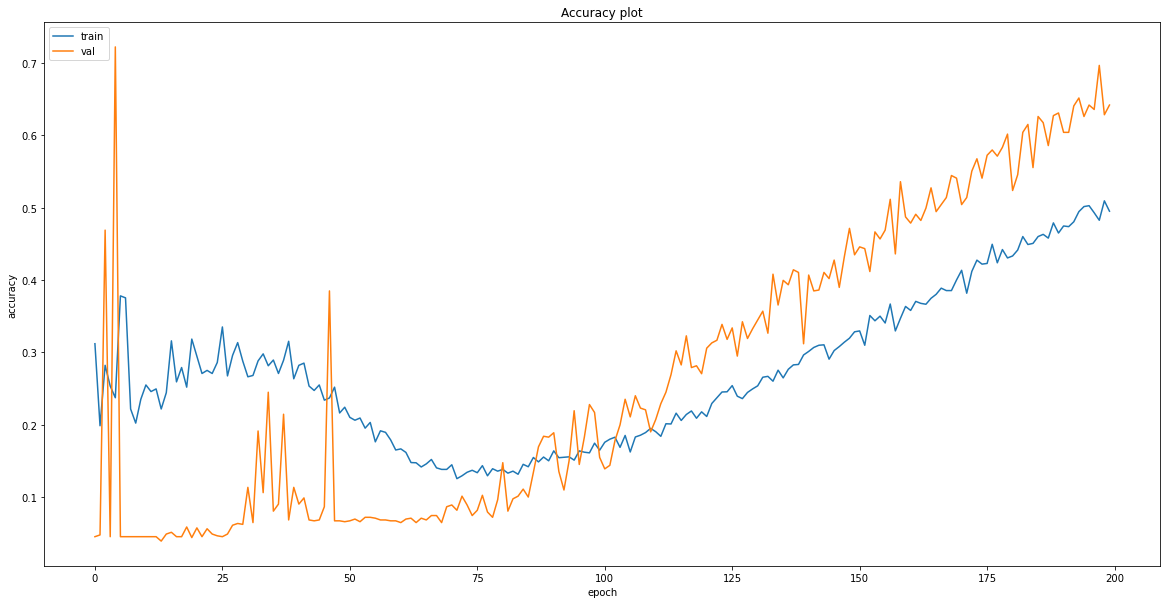

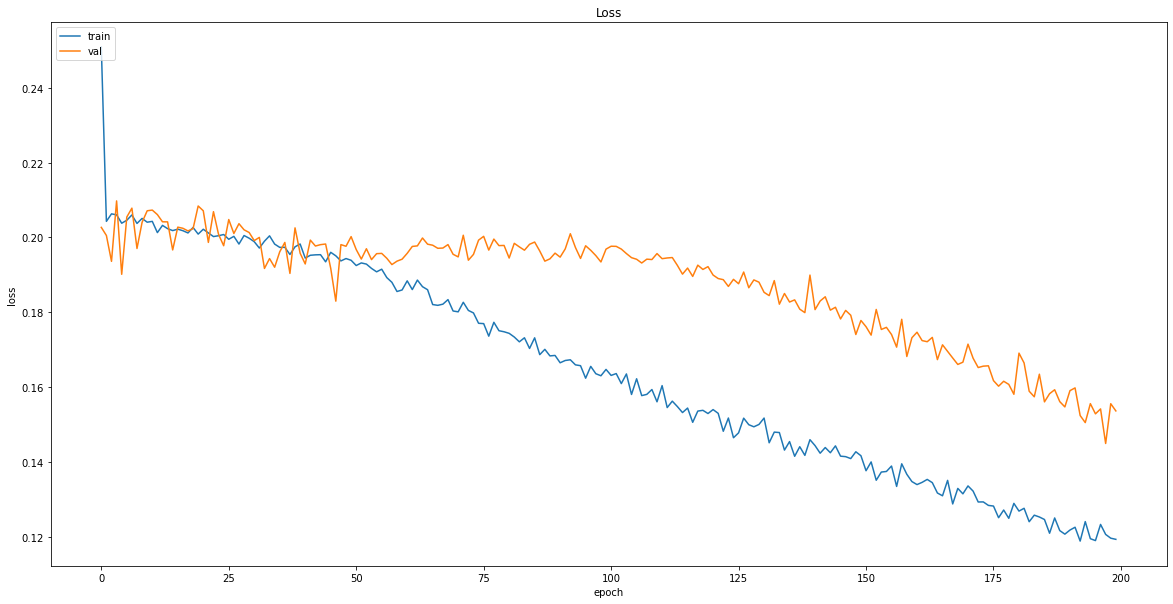

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('moutai_image_cnn_buy_hold_sell_20.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [28]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


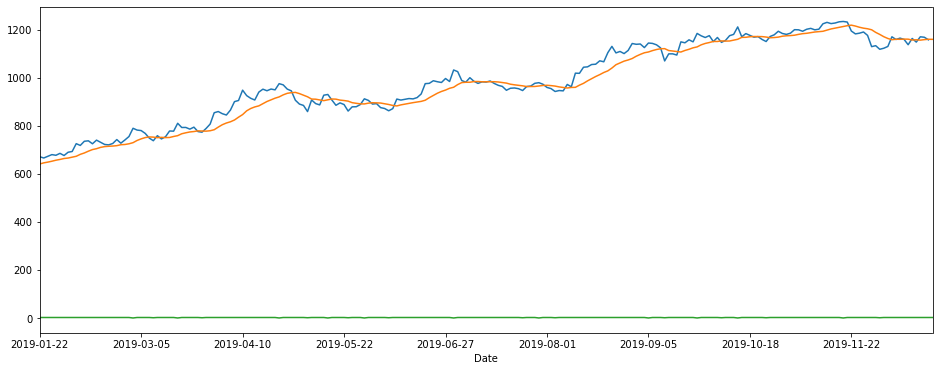

In [29]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [30]:
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
df2.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [31]:
df2 = df2.iloc[-5:]
df2.head(20)

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,589.000000,582.108121,-38.732394,1.228418e+09,2.0
2018-12-14,601.750000,585.129949,-20.774648,1.232458e+09,2.0
2018-12-17,592.960022,586.334575,-33.154899,1.230002e+09,2.0
2018-12-18,590.520020,586.978490,-36.591522,1.227513e+09,2.0
2018-12-19,590.940002,587.587953,-37.872279,1.229435e+09,2.0


In [32]:
df2 = pd.concat([df2,df])
df2.head(20)

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,589.000000,582.108121,-38.732394,1.228418e+09,2.0
2018-12-14,601.750000,585.129949,-20.774648,1.232458e+09,2.0
2018-12-17,592.960022,586.334575,-33.154899,1.230002e+09,2.0
2018-12-18,590.520020,586.978490,-36.591522,1.227513e+09,2.0
2018-12-19,590.940002,587.587953,-37.872279,1.229435e+09,2.0
2019-01-22,686.979980,640.790403,-10.183147,3.503009e+07,2.0
2019-01-23,671.000000,645.438034,-23.857615,3.081787e+07,2.0
2019-01-24,665.659973,648.549101,-28.427209,2.745539e+07,2.0
2019-01-25,672.500000,652.233855,-26.754575,3.037092e+07,2.0


In [33]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [34]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [36]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [37]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [38]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1527 - accuracy: 0.6280 - mean_squared_error: 1.9500 - weighted_accuracy: 0.6280 - weighted_mean_squared_error: 1.9500
Test loss: 0.15274563431739807
Test accuracy: 0.6280193328857422


In [39]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 134, 0: 49, 1: 24})

In [40]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [41]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-41-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-41-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-41-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,0,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,1,2


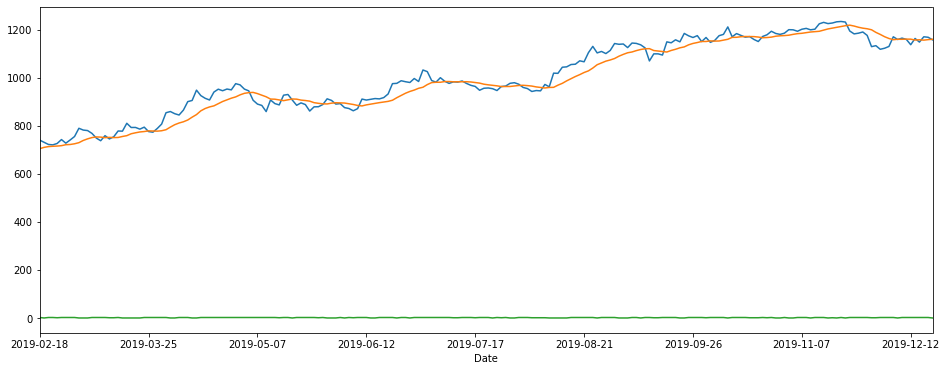

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

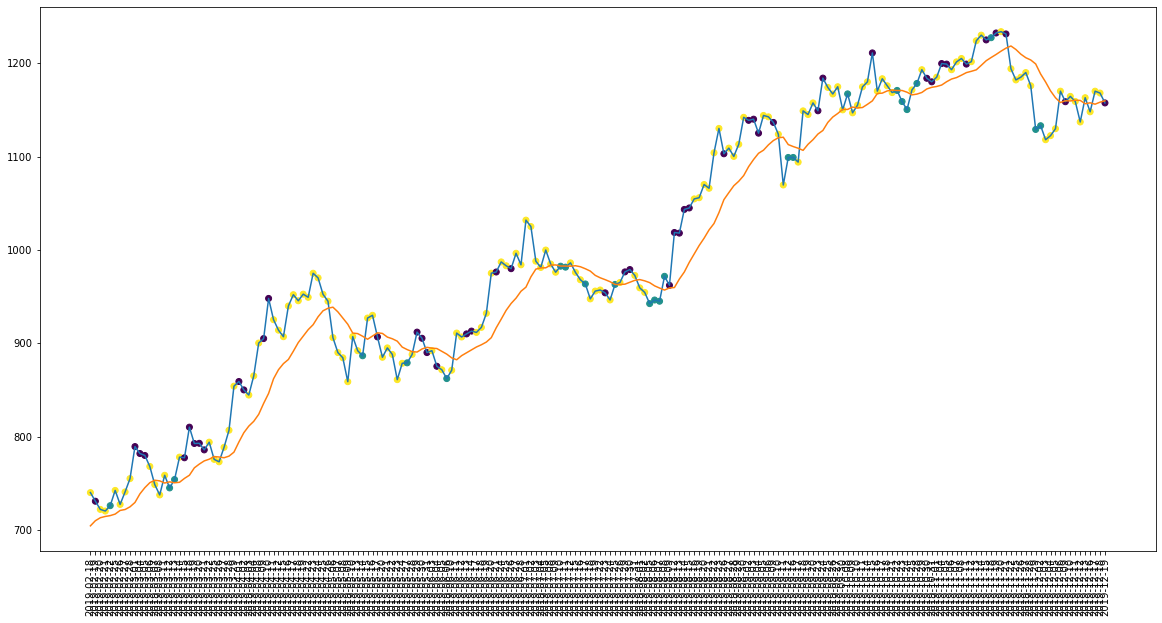

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

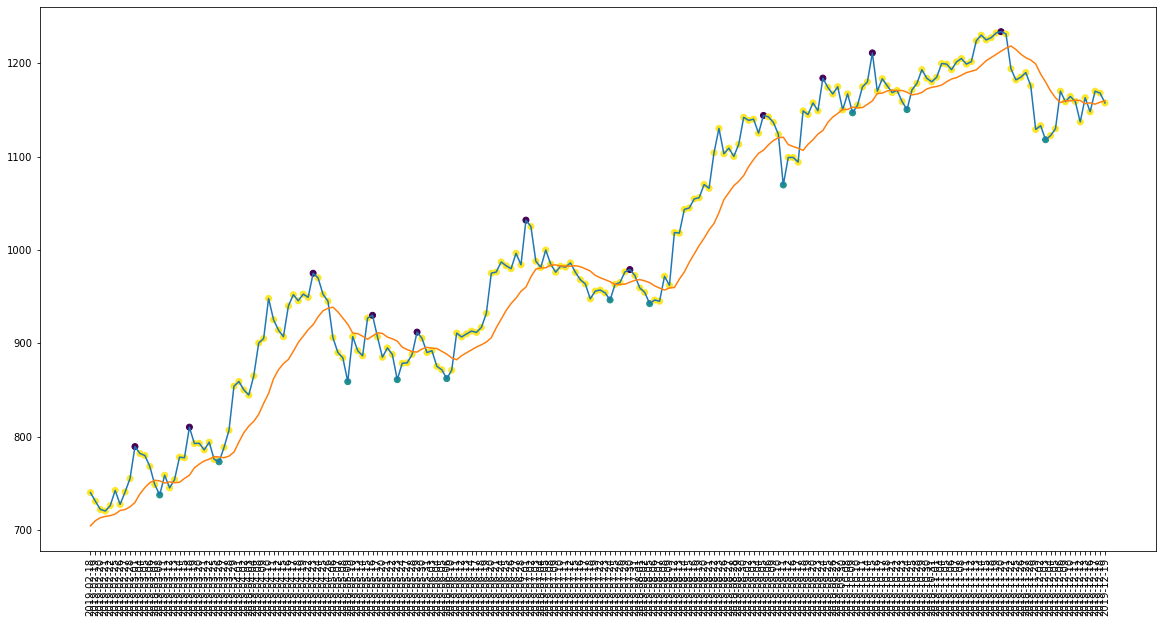

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 21
actual holds but predicted sell: 43
actual predicted holds: 121
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 65.4054054054054%
actual buys: 11
actual sells: 11
actual holds: 185


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 58.333333333333336%
Percentage sells correct: 52.083333333333336%
Percentage holds correct: 85.07462686567165%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $726.010009765625
Shares owned at the moment: 13
Cash capital at the moment: $535.9150151977537


Price increase from previously bought: 8.419354409706802%
Share price: $789.2999877929688
Shares owned at the moment: 0
Cash capital at the moment: $10768.597381942749


Share price: $745.010009765625
Shares owned at the moment: 14
Cash capital at the moment: $309.77435984802287


Price increase from previously bought: 8.437252949186046%
Share price: $810.0900268554688
Shares owned at the moment: 0
Cash capital at the moment: $11619.846269790649


Share price: $886.5700073242188
Shares owned at the moment: 13
Cash capital at the moment: $62.741296813963345


Stop Loss Activated!

Share price: $861.0
Shares owned at the moment: 0
Cash capital at the moment: $11224.960546813963


Share price: $879.0
Shares owned at the moment: 12
Cash capital at the moment: $647.9535468139638


Price increase from previously bought: 10.764792474048889%
Share price: $976.2999877929688
Shares owne

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [49]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


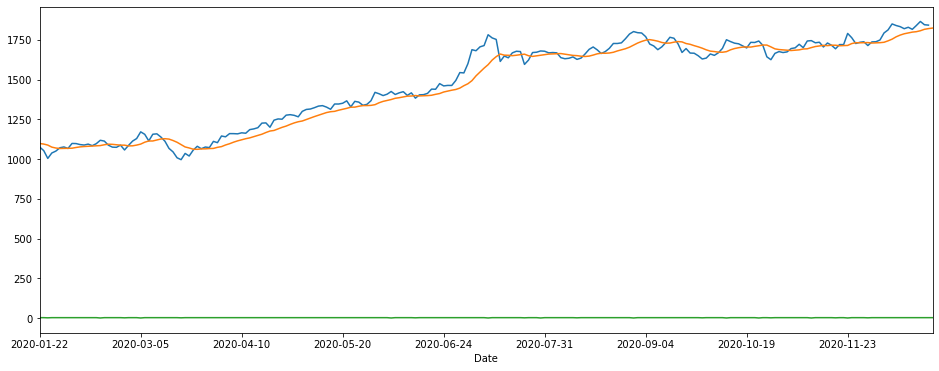

In [50]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [51]:
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])

In [52]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [53]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [56]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [57]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1504 - accuracy: 0.6538 - mean_squared_error: 1.8785 - weighted_accuracy: 0.6538 - weighted_mean_squared_error: 1.8785
Test loss: 0.15038363635540009
Test accuracy: 0.6538461446762085


In [58]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 146, 0: 50, 1: 12})

In [59]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [60]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-60-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-60-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-60-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,0,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,0,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,0,2


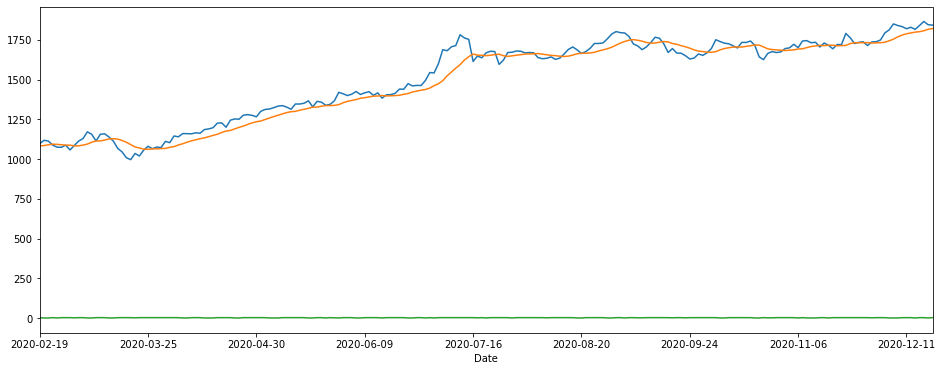

In [61]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

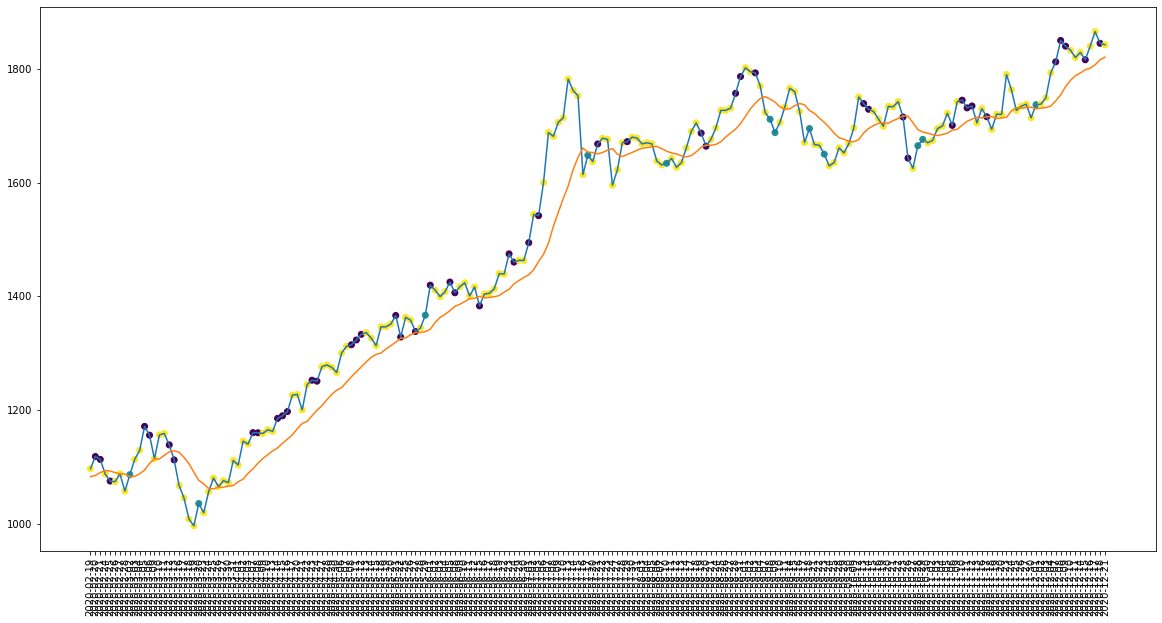

In [62]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

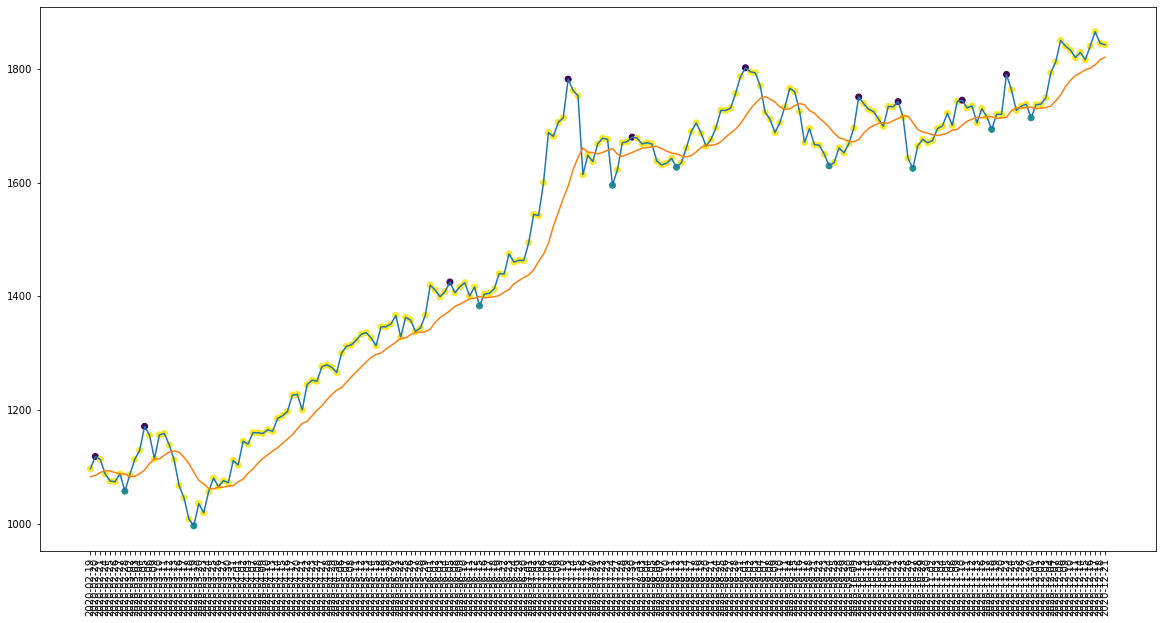

In [63]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [64]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 12
actual holds but predicted sell: 45
actual predicted holds: 132
Percentage buys correct: 0.0%
Percentage sells correct: 40.0%
Percentage holds correct: 69.84126984126983%
actual buys: 9
actual sells: 10
actual holds: 189


In [65]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 75.0%
Percentage sells correct: 53.06122448979592%
Percentage holds correct: 85.61643835616438%


In [66]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1086.010009765625
Shares owned at the moment: 9
Cash capital at the moment: $199.03116436767596


Price increase from previously bought: 7.53018580861613%
Share price: $1171.0
Shares owned at the moment: 0
Cash capital at the moment: $10709.048914367675


Share price: $1035.280029296875
Shares owned at the moment: 10
Cash capital at the moment: $327.7784205932603


Price increase from previously bought: 11.734874056840173%
Share price: $1159.949951171875
Shares owned at the moment: 0
Cash capital at the moment: $11895.379308654783


Share price: $1366.5999755859375
Shares owned at the moment: 8
Cash capital at the moment: $932.5143045043915


Price increase from previously bought: 7.599610097672405%
Share price: $1474.5
Shares owned at the moment: 0
Cash capital at the moment: $12696.075304504391


Share price: $1648.050048828125
Shares owned at the moment: 7
Cash capital at the moment: $1127.9999992675748


Stop Loss Activated!

Share price: $1595.300048828125
Shares own

In [67]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [68]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


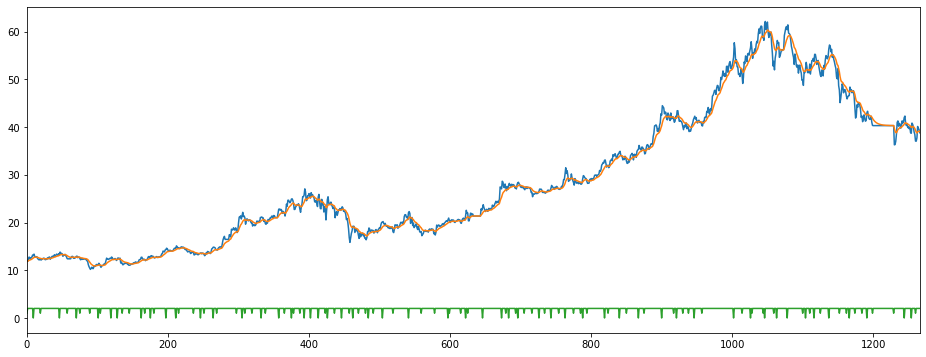

In [69]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [70]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [71]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [73]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [75]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(1248, 64, 64, 1)

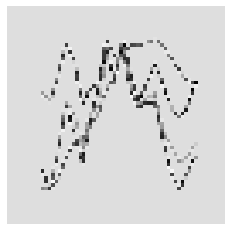

In [76]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [77]:
X = X/255

In [78]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [79]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [80]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [82]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2
 1 0 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2
 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 0
 2 2 2 0 0 1 2 2 2 2 2 2 2 0 2 2 1 1 2 1 2 2 0 2 0 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 

{0: 7.920634920634921, 1: 6.789115646258503, 2: 0.3667769202499081}
Epoch 1/200
8/8 [==============================] - 4s 448ms/step - loss: 0.3174 - accuracy: 0.3988 - mse: 2.8343 - weighted_accuracy: 0.2852 - weighted_mse: 3.0960 - val_loss: 0.2412 - val_accuracy: 0.0400 - val_mse: 0.9649 - val_weighted_accuracy: 0.0400 - val_weighted_mse: 0.9649
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2249 - accuracy: 0.2495 - mse: 1.2731 - weighted_accuracy: 0.4204 - weighted_mse: 1.1835 - val_loss: 0.2061 - val_accuracy: 0.0560 - val_mse: 1.1070 - val_weighted_accuracy: 0.0560 - val_weighted_mse: 1.1070
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2126 - accuracy: 0.2996 - mse: 1.5103 - weighted_accuracy: 0.3306 - weighted_mse: 1.4437 - val_loss: 0.2048 - val_accuracy: 0.1520 - val_mse: 0.8823 - val_weighted_accuracy: 0.1520 - val_weighted_mse: 0.8823
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2123 - accu

Epoch 29/200
8/8 [==============================] - 0s 17ms/step - loss: 0.1996 - accuracy: 0.2916 - mse: 1.1786 - weighted_accuracy: 0.3651 - weighted_mse: 1.1579 - val_loss: 0.1985 - val_accuracy: 0.0520 - val_mse: 0.9110 - val_weighted_accuracy: 0.0520 - val_weighted_mse: 0.9110
Epoch 30/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1988 - accuracy: 0.3116 - mse: 1.1801 - weighted_accuracy: 0.3963 - weighted_mse: 1.1932 - val_loss: 0.2006 - val_accuracy: 0.0520 - val_mse: 0.9593 - val_weighted_accuracy: 0.0520 - val_weighted_mse: 0.9593
Epoch 31/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1989 - accuracy: 0.3046 - mse: 1.1735 - weighted_accuracy: 0.3161 - weighted_mse: 1.1900 - val_loss: 0.2043 - val_accuracy: 0.0600 - val_mse: 0.9664 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 0.9664
Epoch 32/200
8/8 [==============================] - 0s 17ms/step - loss: 0.2041 - accuracy: 0.2174 - mse: 1.2022 - weighted_accuracy: 0.3254 - weighted

Epoch 58/200
8/8 [==============================] - 0s 13ms/step - loss: 0.1956 - accuracy: 0.3006 - mse: 1.2248 - weighted_accuracy: 0.4180 - weighted_mse: 1.2340 - val_loss: 0.2000 - val_accuracy: 0.0600 - val_mse: 0.9463 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 0.9463
Epoch 59/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1940 - accuracy: 0.3347 - mse: 1.1422 - weighted_accuracy: 0.4308 - weighted_mse: 1.1438 - val_loss: 0.2054 - val_accuracy: 0.0640 - val_mse: 0.9263 - val_weighted_accuracy: 0.0640 - val_weighted_mse: 0.9263
Epoch 60/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1957 - accuracy: 0.2826 - mse: 1.2086 - weighted_accuracy: 0.3977 - weighted_mse: 1.1768 - val_loss: 0.1985 - val_accuracy: 0.0600 - val_mse: 1.0094 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 1.0094
Epoch 61/200
8/8 [==============================] - 0s 13ms/step - loss: 0.1946 - accuracy: 0.3377 - mse: 1.1637 - weighted_accuracy: 0.4361 - weighted

Epoch 87/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1898 - accuracy: 0.2525 - mse: 1.1789 - weighted_accuracy: 0.4870 - weighted_mse: 1.1420 - val_loss: 0.1984 - val_accuracy: 0.0600 - val_mse: 0.9822 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 0.9822
Epoch 88/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1877 - accuracy: 0.2685 - mse: 1.2238 - weighted_accuracy: 0.4690 - weighted_mse: 1.2363 - val_loss: 0.1970 - val_accuracy: 0.0640 - val_mse: 0.9632 - val_weighted_accuracy: 0.0640 - val_weighted_mse: 0.9632
Epoch 89/200
8/8 [==============================] - 0s 13ms/step - loss: 0.1905 - accuracy: 0.2876 - mse: 1.1764 - weighted_accuracy: 0.4211 - weighted_mse: 1.1739 - val_loss: 0.1905 - val_accuracy: 0.0560 - val_mse: 1.0189 - val_weighted_accuracy: 0.0560 - val_weighted_mse: 1.0189
Epoch 90/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1850 - accuracy: 0.2705 - mse: 1.2335 - weighted_accuracy: 0.4978 - weighted

Epoch 144/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1661 - accuracy: 0.1874 - mse: 1.3143 - weighted_accuracy: 0.5910 - weighted_mse: 1.3054 - val_loss: 0.1940 - val_accuracy: 0.0920 - val_mse: 1.1103 - val_weighted_accuracy: 0.0920 - val_weighted_mse: 1.1103
Epoch 145/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1701 - accuracy: 0.1784 - mse: 1.2748 - weighted_accuracy: 0.5813 - weighted_mse: 1.2784 - val_loss: 0.1967 - val_accuracy: 0.1000 - val_mse: 1.0170 - val_weighted_accuracy: 0.1000 - val_weighted_mse: 1.0170
Epoch 146/200
8/8 [==============================] - 0s 16ms/step - loss: 0.1606 - accuracy: 0.2104 - mse: 1.2806 - weighted_accuracy: 0.6426 - weighted_mse: 1.3006 - val_loss: 0.1920 - val_accuracy: 0.0920 - val_mse: 1.1536 - val_weighted_accuracy: 0.0920 - val_weighted_mse: 1.1536
Epoch 147/200
8/8 [==============================] - 0s 17ms/step - loss: 0.1677 - accuracy: 0.2134 - mse: 1.4092 - weighted_accuracy: 0.5821 - weig

Epoch 173/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1476 - accuracy: 0.2385 - mse: 1.4166 - weighted_accuracy: 0.6563 - weighted_mse: 1.4490 - val_loss: 0.1940 - val_accuracy: 0.1880 - val_mse: 1.1559 - val_weighted_accuracy: 0.1880 - val_weighted_mse: 1.1559
Epoch 174/200
8/8 [==============================] - 0s 17ms/step - loss: 0.1590 - accuracy: 0.2244 - mse: 1.3443 - weighted_accuracy: 0.6175 - weighted_mse: 1.3742 - val_loss: 0.1933 - val_accuracy: 0.2320 - val_mse: 1.1152 - val_weighted_accuracy: 0.2320 - val_weighted_mse: 1.1152
Epoch 175/200
8/8 [==============================] - 0s 13ms/step - loss: 0.1544 - accuracy: 0.2275 - mse: 1.4093 - weighted_accuracy: 0.6273 - weighted_mse: 1.4466 - val_loss: 0.1939 - val_accuracy: 0.1840 - val_mse: 1.2179 - val_weighted_accuracy: 0.1840 - val_weighted_mse: 1.2179
Epoch 176/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1531 - accuracy: 0.2515 - mse: 1.5253 - weighted_accuracy: 0.6490 - weig

In [83]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19337555766105652
Test accuracy: 0.23999999463558197


In [84]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-6.93836585e-02 -9.87643421e-01 -5.85412025e-01]
 [-1.27024543e+00 -2.46592075e-01 -4.46608961e-01]
 [-1.29396868e+00 -2.10572049e-01 -5.07439375e-01]
 [-1.01262486e+00 -3.54135156e-01 -3.68436933e-01]
 [-1.21992075e+00 -2.44713515e-01 -4.66224849e-01]
 [-1.28077829e+00 -1.97035506e-01 -4.65919256e-01]
 [-5.99688828e-01 -4.80169237e-01 -4.75999892e-01]
 [-3.71097438e-02 -9.30948019e-01 -5.37524819e-01]
 [-2.16958970e-02 -1.10304034e+00 -6.34174943e-01]
 [-1.63210273e+00 -1.93127036e-01 -5.61709285e-01]
 [-1.91517901e+00 -1.12608477e-01 -7.48668611e-01]
 [-1.73965824e+00 -8.23364407e-02 -6.87895298e-01]
 [-8.23732674e-01 -4.22013342e-01 -4.73694682e-01]
 [-1.48418891e+00 -1.65477276e-01 -5.60515761e-01]
 [-1.61865318e+00 -1.27500981e-01 -6.61459267e-01]
 [-6.96192324e-01 -4.68810618e-01 -4.76681530e-01]
 [-1.15631521e+00 -3.06382775e-01 -4.67928290e-01]
 [-3.50186676e-01 -6.06751025e-01 -4.38050807e-01]
 [-1.12976456e+00 -4.08857167e-01 -4.89104033e-01]
 [-1.11526120e+00 -3.70772481e-

Counter({0: 66, 1: 134, 2: 50})

In [85]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 227, 1: 13, 0: 10})

In [86]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 250
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 121
actual holds but predicted sell: 61
actual predicted holds: 45
Percentage buys correct: 76.92307692307692%
Percentage sells correct: 50.0%
Percentage holds correct: 19.823788546255507%
actual buys: 13
actual sells: 10
actual holds: 227


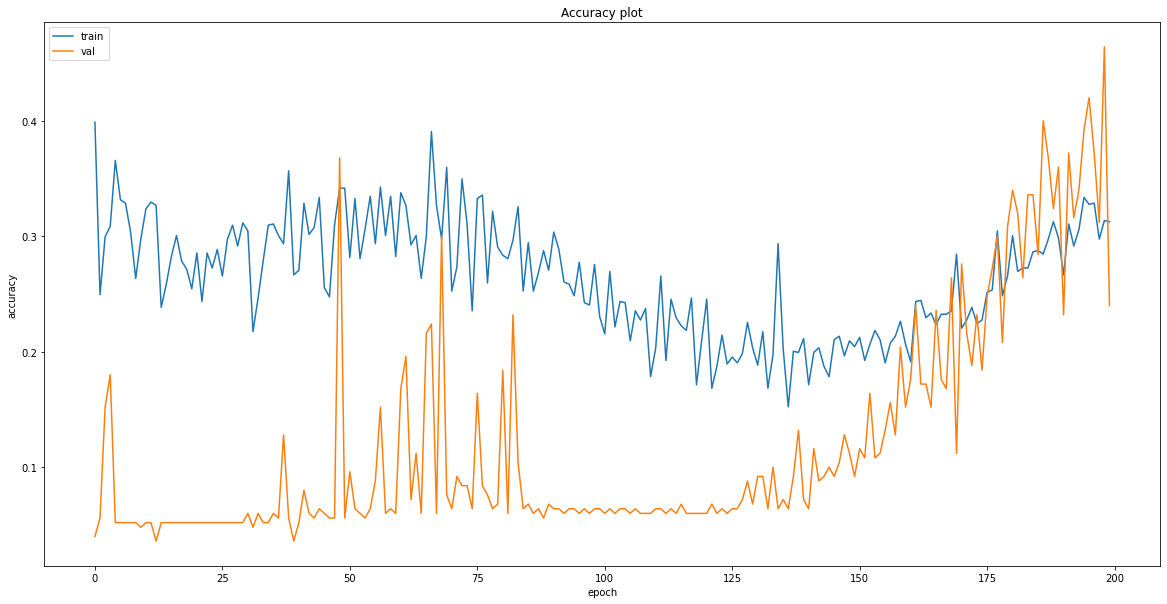

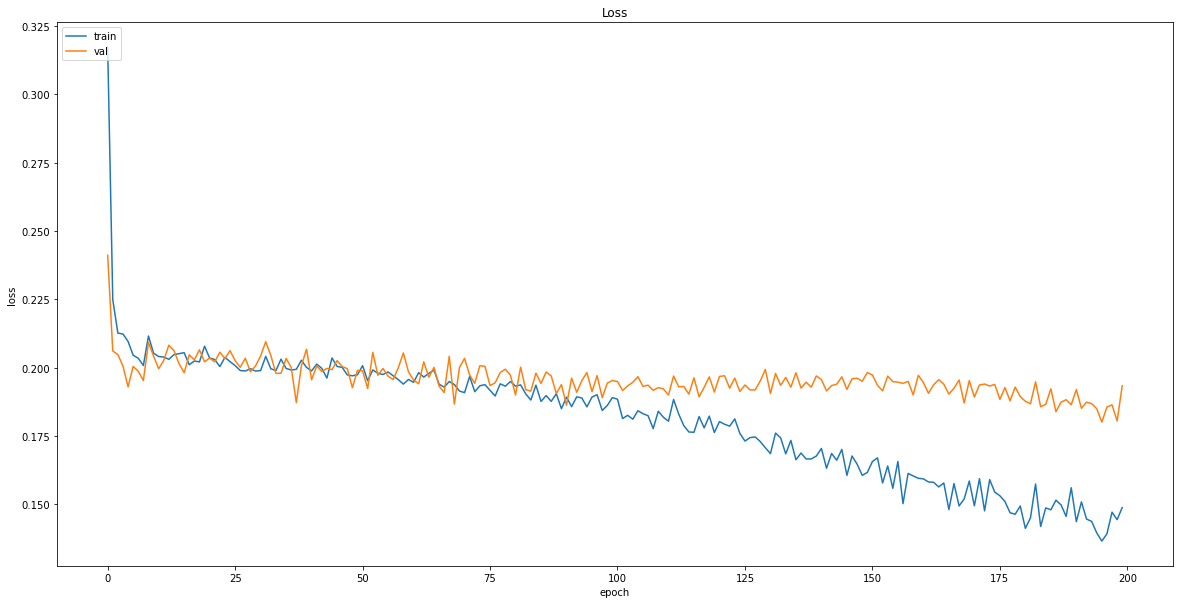

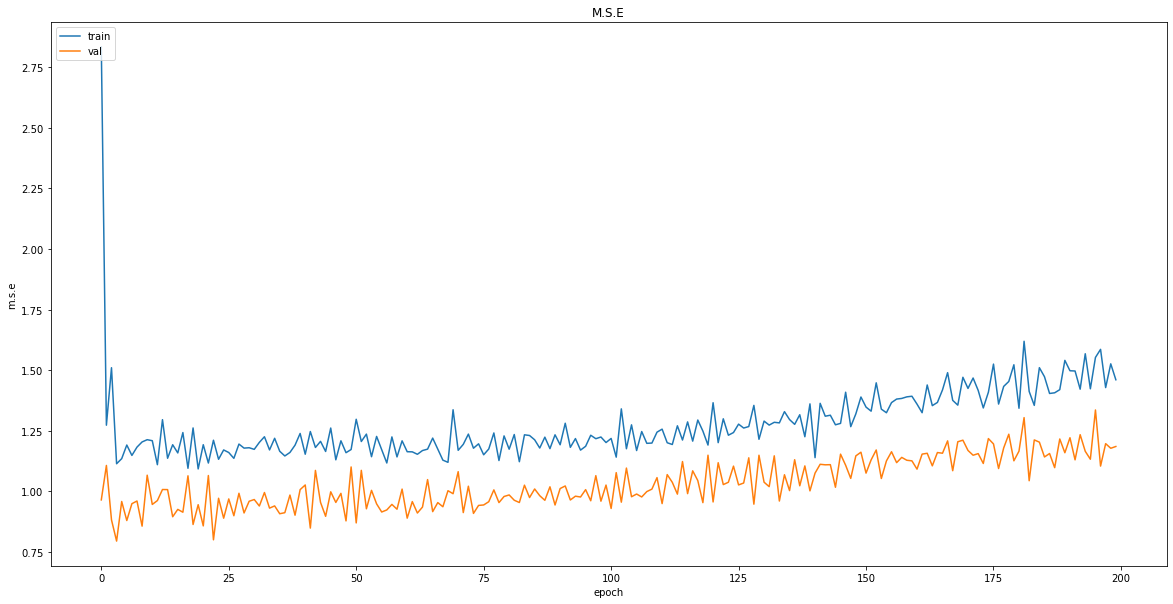

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [88]:
# Save model
model.save("models/{}".format('midea_image_cnn_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/midea_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

#### Non-Recession

In [89]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


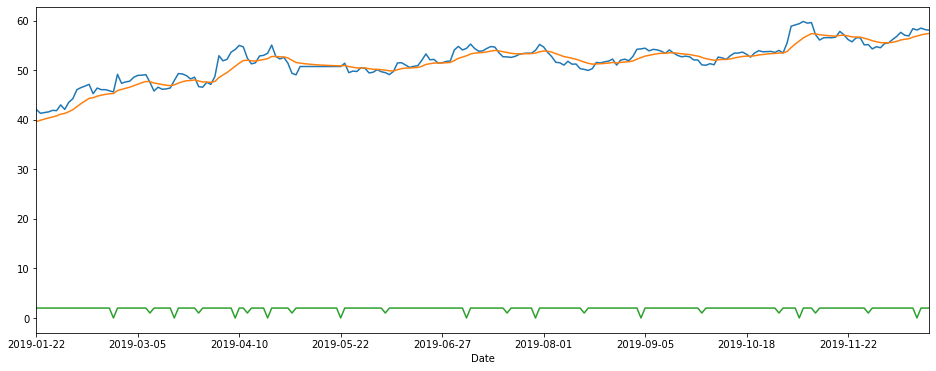

In [90]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [91]:
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])

In [92]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1
        
# willr_data = np.array(willr_data)
# price_data = np.array(price_data)
# ema_data = np.array(ema_data)
# obv_data = np.array(obv_data)

In [93]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [95]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [96]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [97]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1919 - accuracy: 0.2319 - mean_squared_error: 1.1542 - weighted_accuracy: 0.2319 - weighted_mean_squared_error: 1.1542
Test loss: 0.19193506240844727
Test accuracy: 0.23188406229019165


In [98]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 40, 1: 106, 0: 61})

In [99]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [100]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-100-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-100-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-100-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,1,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,1,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,1,2


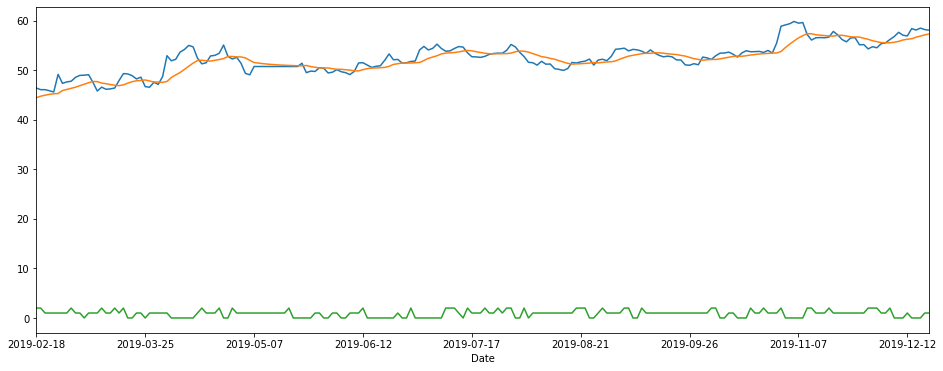

In [101]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

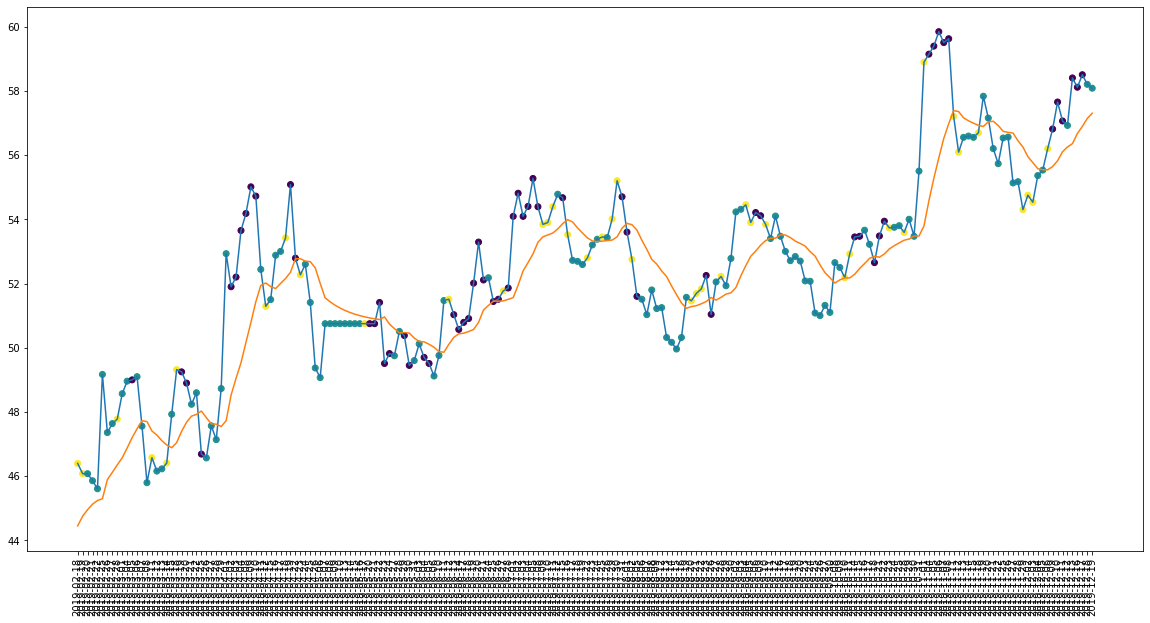

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

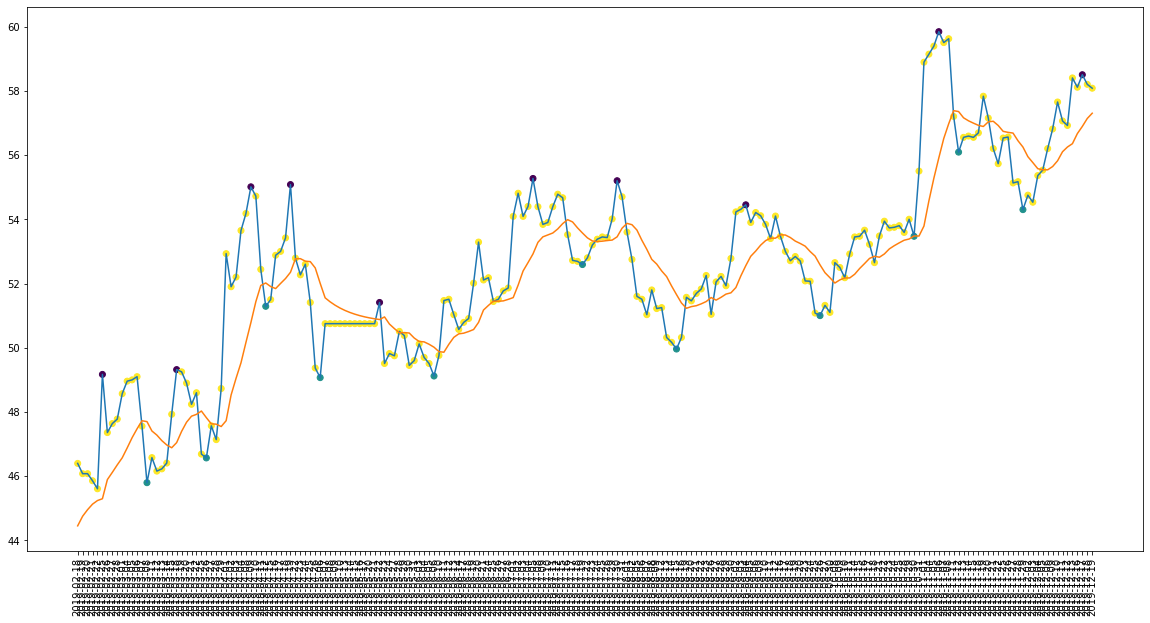

In [103]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [104]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 97
actual holds but predicted sell: 55
actual predicted holds: 34
Percentage buys correct: 72.72727272727273%
Percentage sells correct: 60.0%
Percentage holds correct: 18.27956989247312%
actual buys: 11
actual sells: 10
actual holds: 186


In [105]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 52.38095238095238%
Percentage sells correct: 60.65573770491803%
Percentage holds correct: 80.0%


In [106]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.08000183105469
Shares owned at the moment: 216
Cash capital at the moment: $19.348083404540375


Price increase from previously bought: 6.045177093104659%
Share price: $49.0
Shares owned at the moment: 0
Cash capital at the moment: $10574.24208340454


Share price: $49.099998474121094
Shares owned at the moment: 214
Cash capital at the moment: $37.947060840606355


Stop Loss Activated!

Share price: $47.56000137329102
Shares owned at the moment: 0
Cash capital at the moment: $10187.798293916703


Share price: $47.56000137329102
Shares owned at the moment: 213
Cash capital at the moment: $29.659730601310002


Stop Loss Activated!

Share price: $45.79999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9758.232218542098


Share price: $45.79999923706055
Shares owned at the moment: 212
Cash capital at the moment: $21.930980730056035


Price increase from previously bought: 7.237848798794122%
Share price: $49.25
Shares owned at the moment: 0
Cash capital

In [107]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


#### Recession

In [108]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


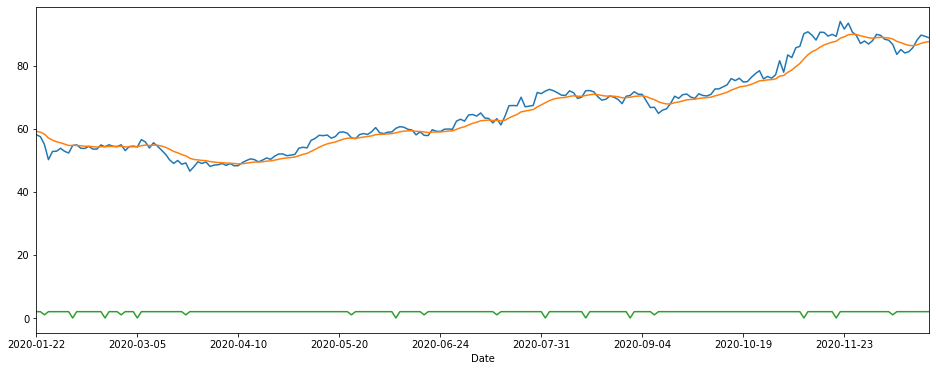

In [109]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [110]:
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-16,58.400002,56.667715,-2.074657,1.246874e+09,2.0
2019-12-17,58.110001,56.889605,-8.091274,1.225225e+09,0.0
2019-12-18,58.500000,57.137358,-8.538913,1.250810e+09,2.0
2019-12-19,58.200001,57.300842,-19.572930,1.227161e+09,2.0
2019-12-20,58.080002,57.420713,-23.018822,1.213685e+09,2.0


In [111]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [113]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [114]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [115]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1932 - accuracy: 0.2644 - mean_squared_error: 1.1785 - weighted_accuracy: 0.2644 - weighted_mean_squared_error: 1.1785
Test loss: 0.19316738843917847
Test accuracy: 0.26442307233810425


In [116]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 47, 0: 46, 1: 115})

In [117]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [118]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-118-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-118-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-118-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,0,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,0,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,0,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,1,2


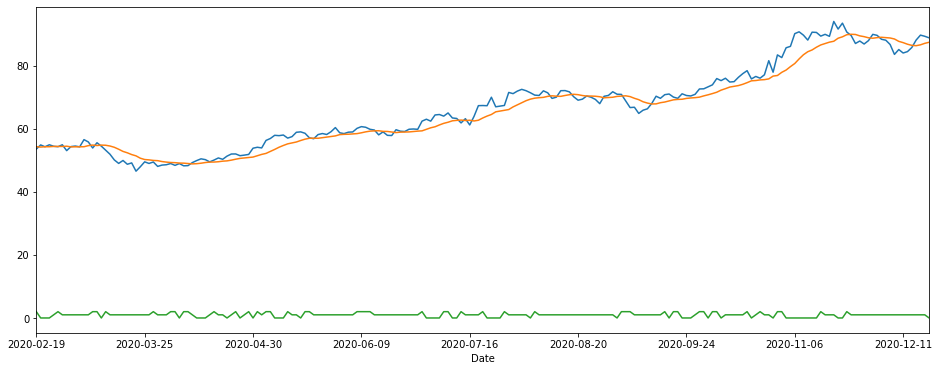

In [119]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

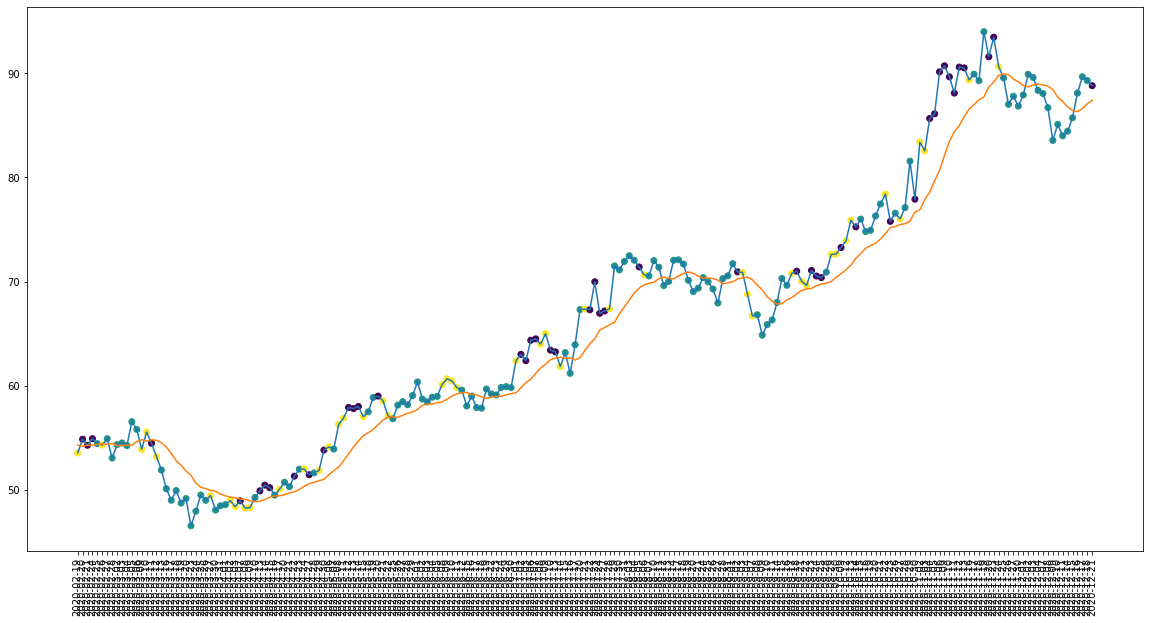

In [120]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

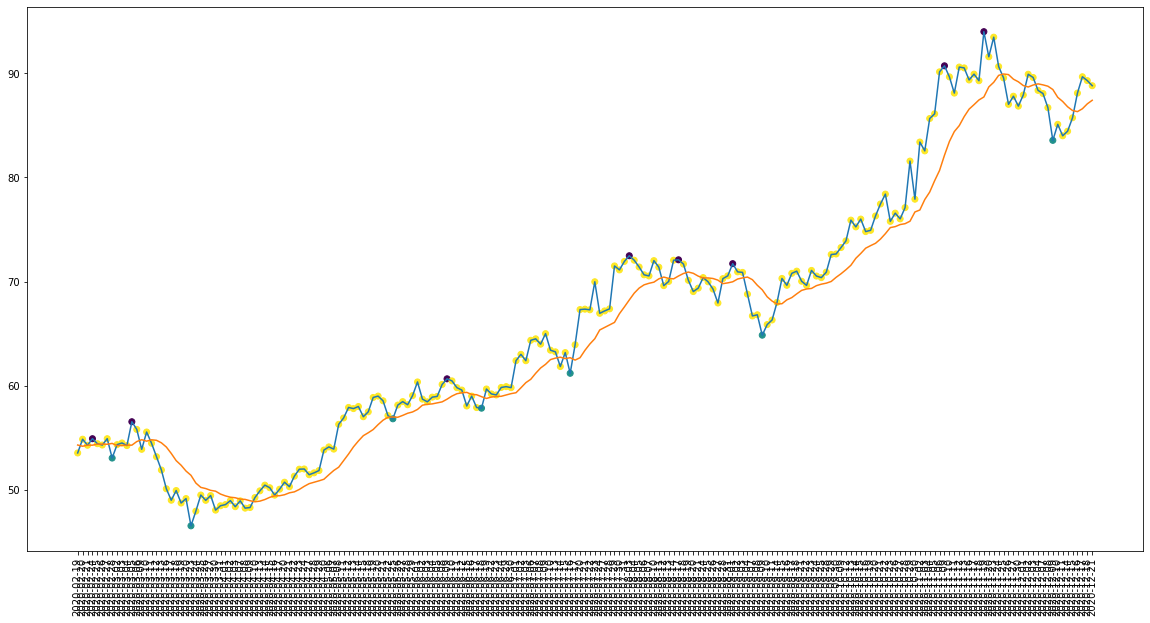

In [121]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [122]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 2
actual sells but predicted hold: 1
actual holds but predicted buy: 103
actual holds but predicted sell: 44
actual predicted holds: 46
Percentage buys correct: 100.0%
Percentage sells correct: 25.0%
Percentage holds correct: 23.83419689119171%
actual buys: 7
actual sells: 8
actual holds: 193


In [123]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 48.69565217391305%
Percentage sells correct: 56.52173913043478%
Percentage holds correct: 89.1304347826087%


In [124]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.43000030517578
Shares owned at the moment: 183
Cash capital at the moment: $11.918046499251432


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9483.49964996719


Share price: $51.9000015258789
Shares owned at the moment: 182
Cash capital at the moment: $11.723421493528804


Stop Loss Activated!

Share price: $50.099998474121094
Shares owned at the moment: 0
Cash capital at the moment: $9104.84809454727


Share price: $50.099998474121094
Shares owned at the moment: 181
Cash capital at the moment: $11.81109649085738


Stop Loss Activated!

Share price: $48.72999954223633
Shares owned at the moment: 0
Cash capital at the moment: $8807.685656363485


Share price: $48.72999954223633
Shares owned at the moment: 180
Cash capital at the moment: $12.164388987537677


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8366.327253329273


Share price: $

In [125]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [126]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


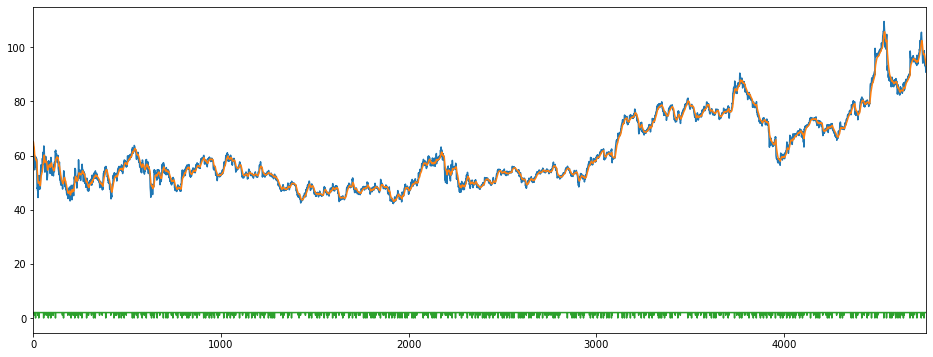

In [127]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [128]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [129]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [130]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [132]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4740, 64, 64, 1)

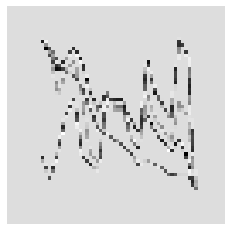

In [133]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [134]:
X = X/255

In [135]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [136]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [137]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [138]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [139]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.141242937853107, 1: 7.348837209302325, 2: 0.36712169619517865}
Epoch 1/200
30/30 [==============================] - 2s 63ms/step - loss: 0.2472 - accuracy: 0.4409 - mse: 1.5752 - weighted_accuracy: 0.3500 - weighted_mse: 1.6995 - val_loss: 0.1923 - val_accuracy: 0.7869 - val_mse: 0.8559 - val_weighted_accuracy: 0.7869 - val_weighted_mse: 0.8559
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2044 - accuracy: 0.4723 - mse: 1.1766 - weighted_accuracy: 0.3504 - weighted_mse: 1.1883 - val_loss: 0.1987 - val_accuracy: 0.3312 - val_mse: 0.9081 - val_weighted_accuracy: 0.3312 - val_weighted_mse: 0.9081
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2054 - accuracy: 0.3914 - mse: 1.1658 - weighted_accuracy: 0.3170 - weighted_mse: 1.1680 - val_loss: 0.1945 - val_accuracy: 0.1688 - val_mse: 0.8818 - val_weighted_accuracy: 0.1688 - val_weighted_mse: 0.8818
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2055 -

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1802 - accuracy: 0.1680 - mse: 1.2902 - weighted_accuracy: 0.5297 - weighted_mse: 1.2499 - val_loss: 0.1963 - val_accuracy: 0.0781 - val_mse: 1.1200 - val_weighted_accuracy: 0.0781 - val_weighted_mse: 1.1200
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1781 - accuracy: 0.1443 - mse: 1.3328 - weighted_accuracy: 0.5355 - weighted_mse: 1.2697 - val_loss: 0.1986 - val_accuracy: 0.0749 - val_mse: 1.0978 - val_weighted_accuracy: 0.0749 - val_weighted_mse: 1.0978
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1767 - accuracy: 0.1580 - mse: 1.2991 - weighted_accuracy: 0.5372 - weighted_mse: 1.2389 - val_loss: 0.1962 - val_accuracy: 0.0749 - val_mse: 1.1210 - val_weighted_accuracy: 0.0749 - val_weighted_mse: 1.1210
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1757 - accuracy: 0.1630 - mse: 1.3187 - weighted_accuracy: 0.5483 - weig

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1526 - accuracy: 0.1907 - mse: 1.5272 - weighted_accuracy: 0.6414 - weighted_mse: 1.5005 - val_loss: 0.1991 - val_accuracy: 0.1487 - val_mse: 1.3302 - val_weighted_accuracy: 0.1487 - val_weighted_mse: 1.3302
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1534 - accuracy: 0.1909 - mse: 1.5037 - weighted_accuracy: 0.6412 - weighted_mse: 1.4741 - val_loss: 0.1975 - val_accuracy: 0.1846 - val_mse: 1.3515 - val_weighted_accuracy: 0.1846 - val_weighted_mse: 1.3515
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1559 - accuracy: 0.1901 - mse: 1.4229 - weighted_accuracy: 0.6252 - weighted_mse: 1.4067 - val_loss: 0.1999 - val_accuracy: 0.1667 - val_mse: 1.2638 - val_weighted_accuracy: 0.1667 - val_weighted_mse: 1.2638
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1536 - accuracy: 0.1886 - mse: 1.5131 - weighted_accuracy: 0.6263 - 

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1343 - accuracy: 0.3085 - mse: 1.8125 - weighted_accuracy: 0.7010 - weighted_mse: 1.9445 - val_loss: 0.1921 - val_accuracy: 0.3049 - val_mse: 1.5705 - val_weighted_accuracy: 0.3049 - val_weighted_mse: 1.5705
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1352 - accuracy: 0.3117 - mse: 1.8333 - weighted_accuracy: 0.6984 - weighted_mse: 2.0056 - val_loss: 0.1895 - val_accuracy: 0.3281 - val_mse: 1.5320 - val_weighted_accuracy: 0.3281 - val_weighted_mse: 1.5320
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1341 - accuracy: 0.3141 - mse: 1.7562 - weighted_accuracy: 0.6922 - weighted_mse: 1.8992 - val_loss: 0.1847 - val_accuracy: 0.3618 - val_mse: 1.6254 - val_weighted_accuracy: 0.3618 - val_weighted_mse: 1.6254
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1312 - accuracy: 0.3362 - mse: 1.8114 - weighted_accuracy: 0.7055

Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1186 - accuracy: 0.4929 - mse: 2.2059 - weighted_accuracy: 0.7537 - weighted_mse: 2.7240 - val_loss: 0.1650 - val_accuracy: 0.5464 - val_mse: 1.8531 - val_weighted_accuracy: 0.5464 - val_weighted_mse: 1.8531
Epoch 145/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1137 - accuracy: 0.5200 - mse: 2.2745 - weighted_accuracy: 0.7715 - weighted_mse: 2.9044 - val_loss: 0.1711 - val_accuracy: 0.5169 - val_mse: 1.8085 - val_weighted_accuracy: 0.5169 - val_weighted_mse: 1.8085
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1163 - accuracy: 0.5105 - mse: 2.2625 - weighted_accuracy: 0.7658 - weighted_mse: 2.8315 - val_loss: 0.1649 - val_accuracy: 0.5570 - val_mse: 1.8762 - val_weighted_accuracy: 0.5570 - val_weighted_mse: 1.8762
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1115 - accuracy: 0.5372 - mse: 2.3396 - weighted_accuracy: 0.794

Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0973 - accuracy: 0.6501 - mse: 2.9354 - weighted_accuracy: 0.8283 - weighted_mse: 4.1834 - val_loss: 0.1382 - val_accuracy: 0.7226 - val_mse: 2.3799 - val_weighted_accuracy: 0.7226 - val_weighted_mse: 2.3799
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0966 - accuracy: 0.6556 - mse: 2.9406 - weighted_accuracy: 0.8264 - weighted_mse: 4.2212 - val_loss: 0.1338 - val_accuracy: 0.7384 - val_mse: 2.3642 - val_weighted_accuracy: 0.7384 - val_weighted_mse: 2.3642
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0967 - accuracy: 0.6656 - mse: 2.9797 - weighted_accuracy: 0.8303 - weighted_mse: 4.2586 - val_loss: 0.1393 - val_accuracy: 0.7036 - val_mse: 2.4803 - val_weighted_accuracy: 0.7036 - val_weighted_mse: 2.4803
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0956 - accuracy: 0.6630 - mse: 2.9673 - weighted_accuracy: 0.8311

In [140]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11504217237234116
Test accuracy: 0.8090717196464539


In [141]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.8955023  -2.762882   -0.10454777]
 [-3.6066687  -0.14470524 -0.6344094 ]
 [-2.3250275  -1.3480649  -0.08247219]
 ...
 [-1.0254569  -2.5272152  -0.02085553]
 [-0.21675432 -3.2174242  -0.5551786 ]
 [-3.7279952  -0.06139338 -0.7388826 ]]


Counter({2: 831, 1: 43, 0: 74})

In [142]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 44, 1: 43})

In [143]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 38
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 37
actual holds but predicted buy: 39
actual holds but predicted sell: 66
actual predicted holds: 756
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 15.909090909090908%
Percentage holds correct: 87.8048780487805%
actual buys: 43
actual sells: 44
actual holds: 861


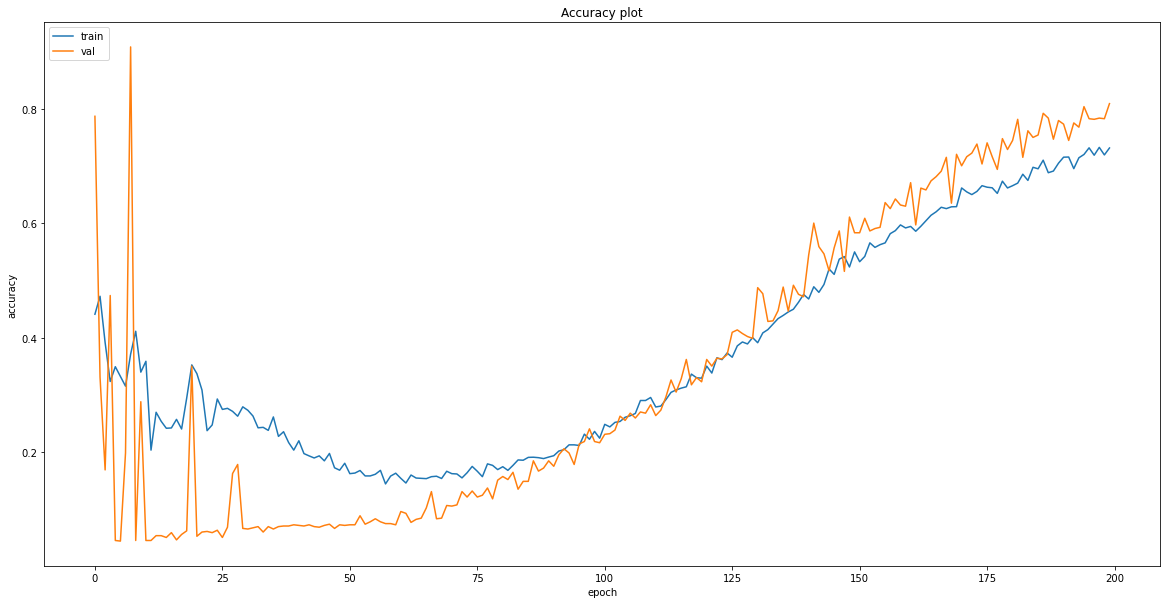

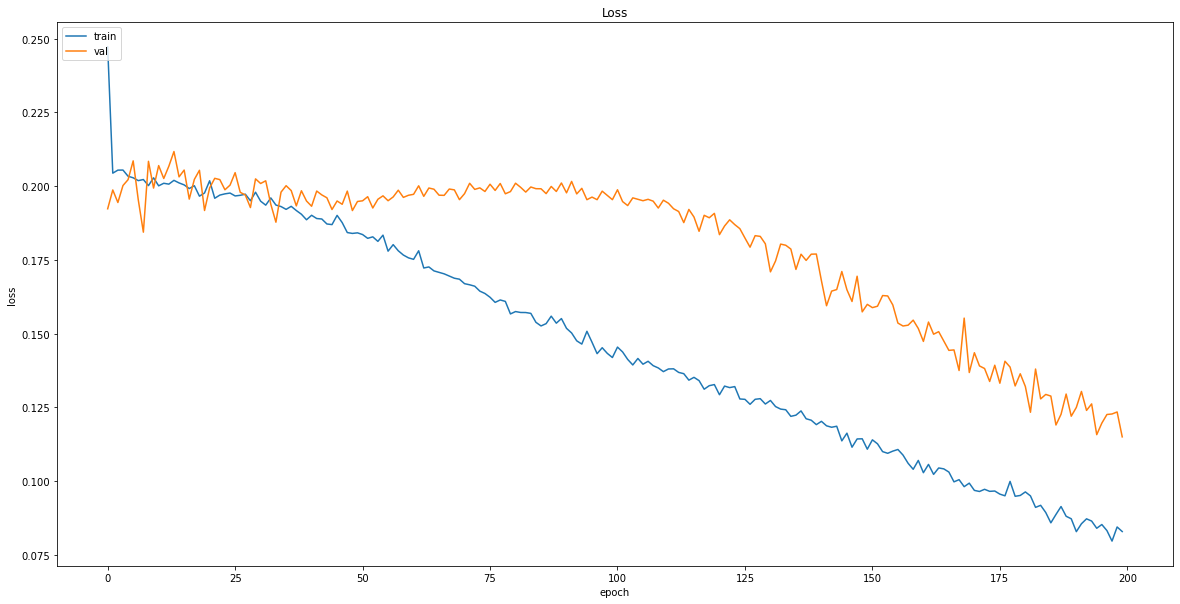

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [145]:
# Save model
model.save("models/{}".format('wmt_image_cnn_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/wmt_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

#### Non-Recession

In [146]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,93.110001,95.261110,-89.379251,98530500.0,2.0
2018-12-14,92.959999,94.907093,-91.448238,90488200.0,2.0
2018-12-17,91.849998,94.436771,-96.508742,78994600.0,2.0
2018-12-18,90.769997,93.872652,-93.531353,69992800.0,2.0
2018-12-19,91.080002,93.443013,-90.243914,79599500.0,2.0


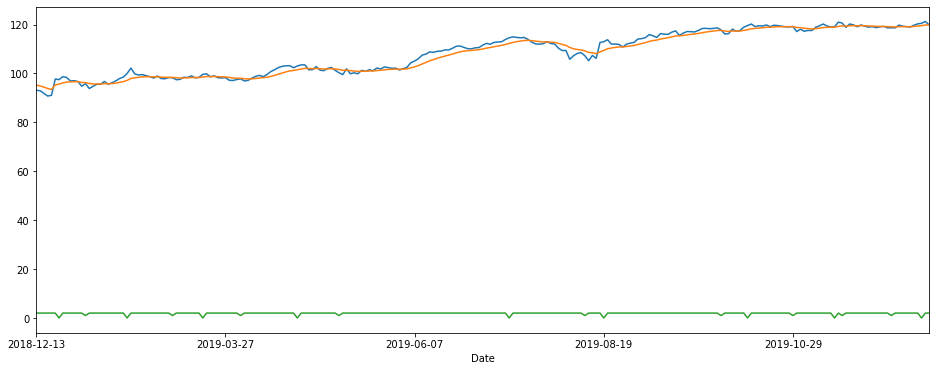

In [147]:
#%matplotlib notebook
df2['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df2['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df2['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [148]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [150]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [151]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [152]:
model = tf.keras.models.load_model("models/wmt_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1144 - accuracy: 0.7982 - mean_squared_error: 3.0352 - weighted_accuracy: 0.7982 - weighted_mean_squared_error: 3.0352
Test loss: 0.1144394651055336
Test accuracy: 0.7981651425361633


In [153]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 184, 0: 21, 1: 13})

In [154]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [155]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-155-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-155-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-155-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,2,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


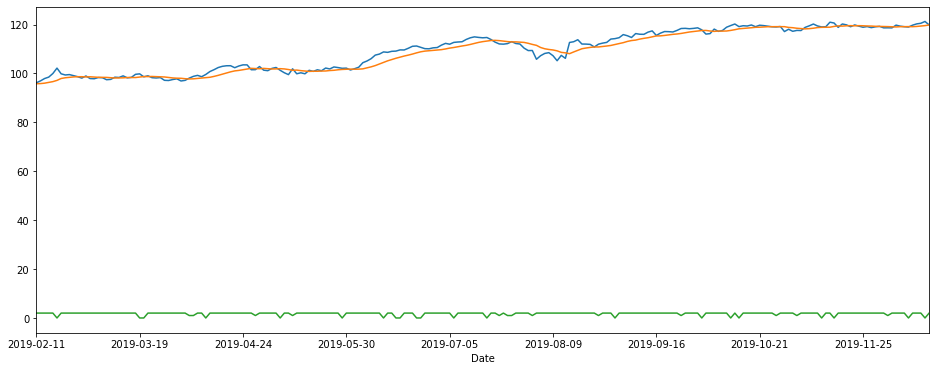

In [156]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

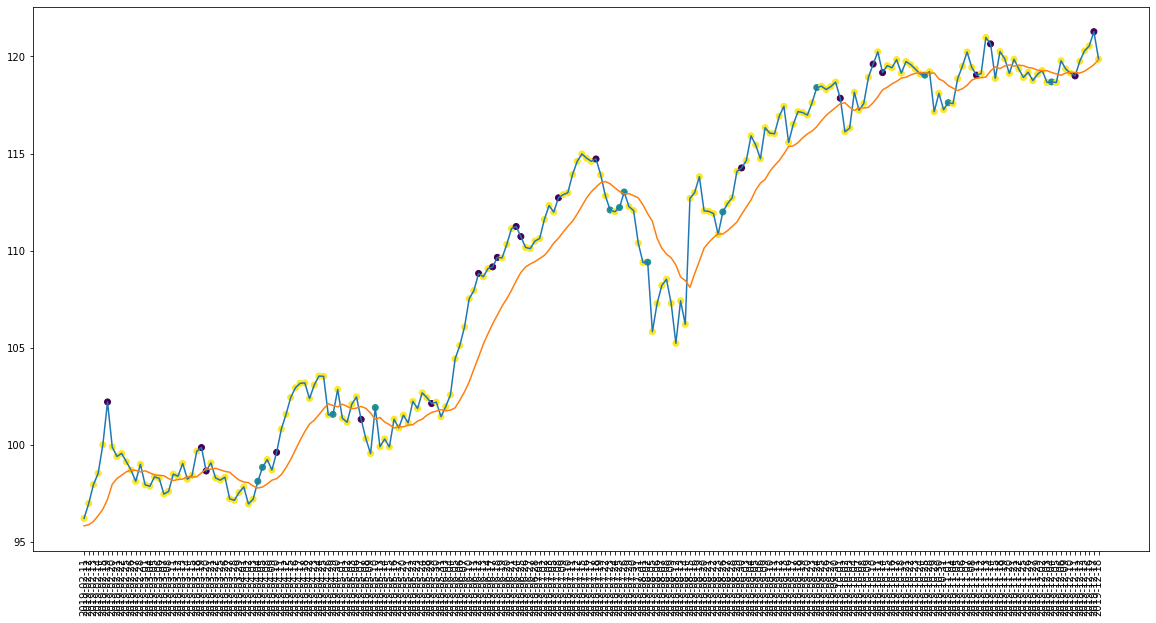

In [157]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

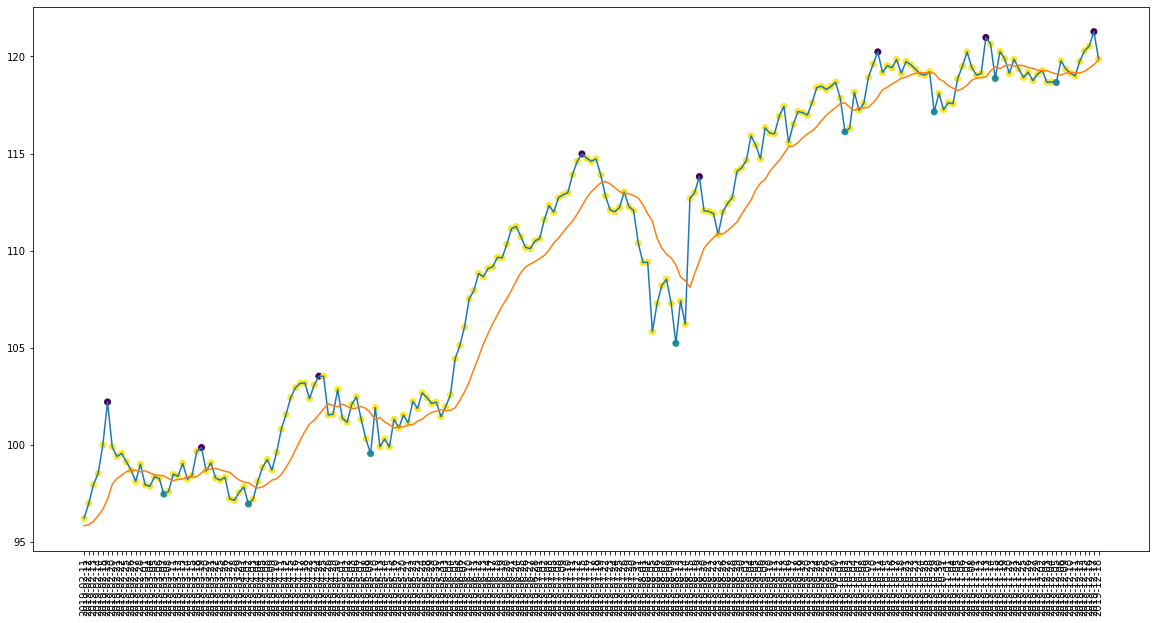

In [158]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [159]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 13
actual holds but predicted sell: 18
actual predicted holds: 171
Percentage buys correct: 0.0%
Percentage sells correct: 37.5%
Percentage holds correct: 84.65346534653466%
actual buys: 8
actual sells: 8
actual holds: 202


In [160]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 46.15384615384615%
Percentage sells correct: 52.38095238095238%
Percentage holds correct: 85.79234972677595%


In [161]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.11000061035156
Shares owned at the moment: 101
Cash capital at the moment: $63.63988568496643


Price increase from previously bought: 10.61213404839345%
Share price: $108.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $11024.235099946975


Share price: $112.08999633789062
Shares owned at the moment: 98
Cash capital at the moment: $9.207204820631887


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10351.04868499565


Share price: $111.98999786376952
Shares owned at the moment: 92
Cash capital at the moment: $19.63541206932132


Price increase from previously bought: 6.511275519186288%
Share price: $119.61000061035156
Shares owned at the moment: 0
Cash capital at the moment: $10993.494138067246


Share price: $119.04000091552734
Shares owned at the moment: 92
Cash capital at the moment: $11.696933607101528




Capital at the end of test period: $11008.492409605025
profit gained:

In [162]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [163]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-13,119.760002,119.241902,-18.750000,211183700.0,2.0
2019-12-16,120.290001,119.403148,-11.145518,216550000.0,2.0
2019-12-17,120.540001,119.578049,-20.610623,221900700.0,0.0
2019-12-18,121.279999,119.839887,-9.813044,226476500.0,2.0
2019-12-19,119.860001,119.842981,-42.990581,221373500.0,2.0


In [164]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [166]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [167]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [168]:
model = tf.keras.models.load_model("models/wmt_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1082 - accuracy: 0.8311 - mean_squared_error: 3.0801 - weighted_accuracy: 0.8311 - weighted_mean_squared_error: 3.0801
Test loss: 0.10815005004405975
Test accuracy: 0.8310502171516418


In [169]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 196, 0: 15, 1: 8})

In [170]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [171]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-171-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-171-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-171-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


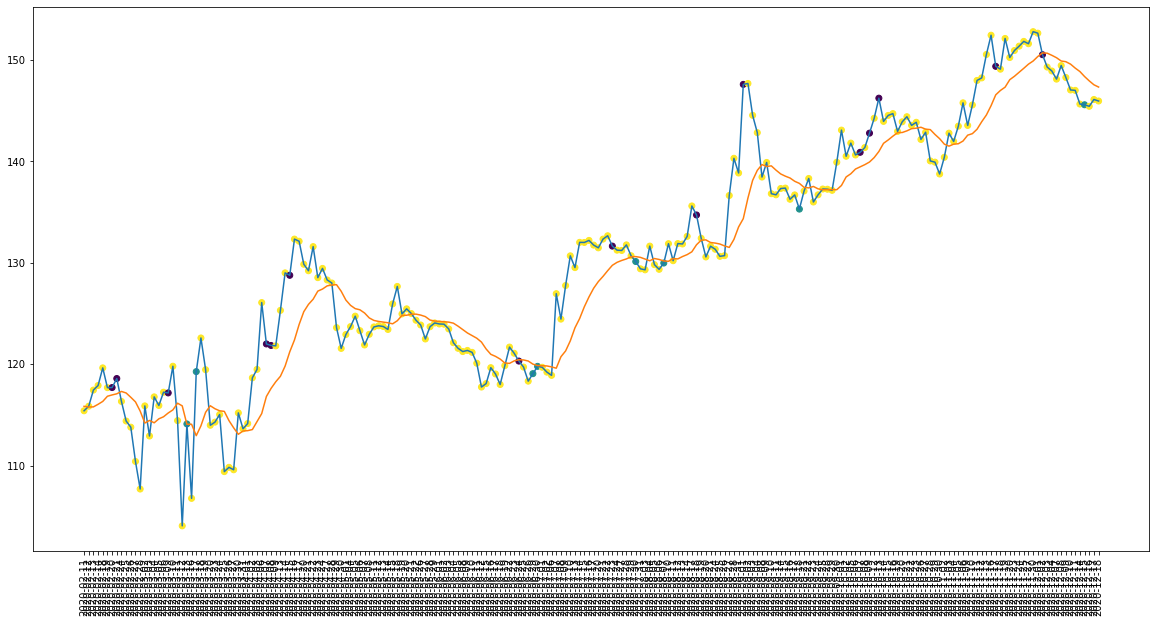

In [172]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

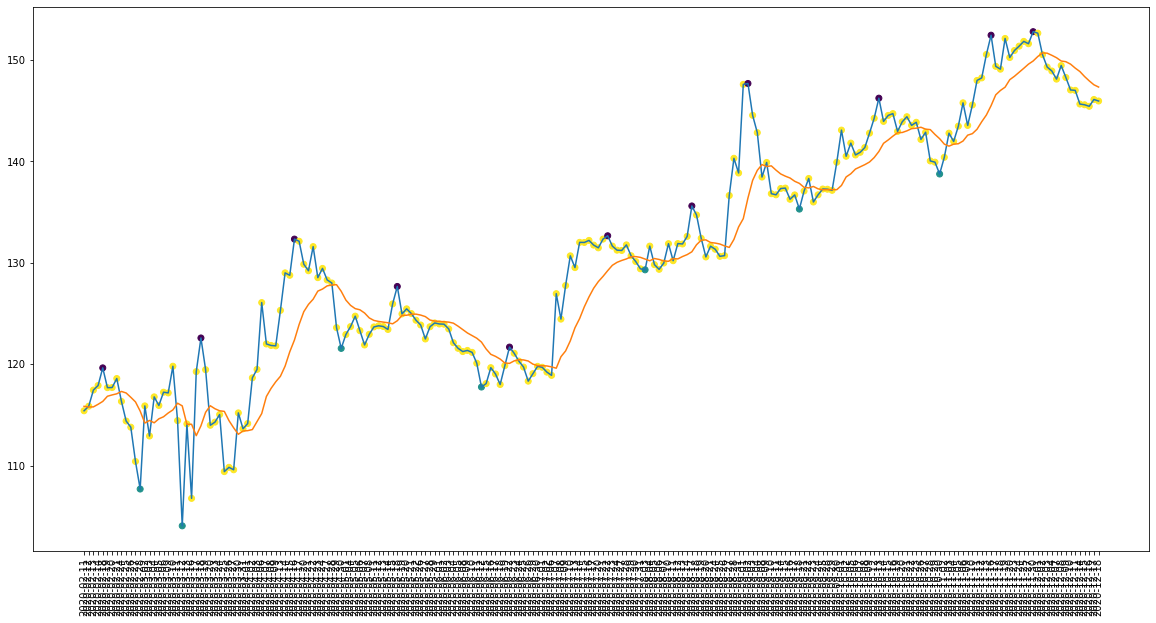

In [173]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [174]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 7
actual holds but predicted sell: 14
actual predicted holds: 180
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 89.55223880597015%
actual buys: 7
actual sells: 11
actual holds: 201


In [175]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 75.0%
Percentage sells correct: 53.333333333333336%
Percentage holds correct: 84.61538461538461%


In [176]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $114.0999984741211
Shares owned at the moment: 87
Cash capital at the moment: $46.00170811653152


Stop Loss Activated!

Share price: $106.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9308.579563457492


Share price: $119.26000213623048
Shares owned at the moment: 77
Cash capital at the moment: $100.30609351539715


Stop Loss Activated!

Share price: $113.97000122070312
Shares owned at the moment: 0
Cash capital at the moment: $8851.863039751053


Share price: $119.05999755859376
Shares owned at the moment: 74
Cash capital at the moment: $17.194510911940597


Price increase from previously bought: 10.262879960183536%
Share price: $131.63999938964844
Shares owned at the moment: 0
Cash capital at the moment: $9731.765725870131


Share price: $130.1199951171875
Shares owned at the moment: 74
Cash capital at the moment: $76.40666819190847


Price increase from previously bought: 13.115003427228178%
Share price: $147.58999633789062
Shares owned at t

In [177]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [178]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


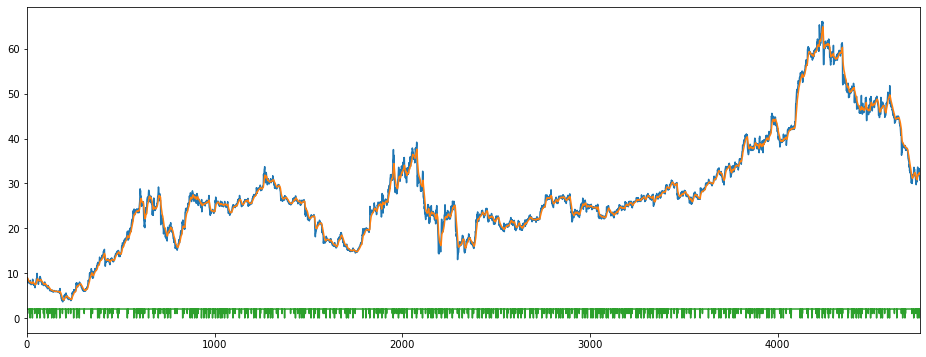

In [179]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [180]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [181]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [182]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [184]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4740, 64, 64, 1)

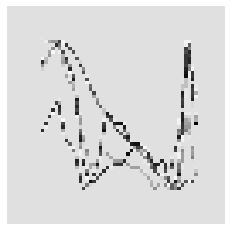

In [185]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [186]:
X = X/255

In [187]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [188]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [189]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [190]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [191]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.30635838150289, 1: 7.181818181818182, 2: 0.36712169619517865}
Epoch 1/200
30/30 [==============================] - 2s 66ms/step - loss: 0.2471 - accuracy: 0.4607 - mse: 1.5113 - weighted_accuracy: 0.3407 - weighted_mse: 1.6242 - val_loss: 0.1869 - val_accuracy: 0.7373 - val_mse: 0.8888 - val_weighted_accuracy: 0.7373 - val_weighted_mse: 0.8888
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2038 - accuracy: 0.4586 - mse: 1.1500 - weighted_accuracy: 0.3598 - weighted_mse: 1.1759 - val_loss: 0.1992 - val_accuracy: 0.3914 - val_mse: 0.8999 - val_weighted_accuracy: 0.3914 - val_weighted_mse: 0.8999
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2056 - accuracy: 0.4119 - mse: 1.1699 - weighted_accuracy: 0.2941 - weighted_mse: 1.1763 - val_loss: 0.1952 - val_accuracy: 0.6930 - val_mse: 0.9131 - val_weighted_accuracy: 0.6930 - val_weighted_mse: 0.9131
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2045 -

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1882 - accuracy: 0.2740 - mse: 1.1969 - weighted_accuracy: 0.4578 - weighted_mse: 1.1905 - val_loss: 0.1956 - val_accuracy: 0.1255 - val_mse: 1.0382 - val_weighted_accuracy: 0.1255 - val_weighted_mse: 1.0382
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1877 - accuracy: 0.2453 - mse: 1.2211 - weighted_accuracy: 0.4382 - weighted_mse: 1.1949 - val_loss: 0.1903 - val_accuracy: 0.1783 - val_mse: 1.0404 - val_weighted_accuracy: 0.1783 - val_weighted_mse: 1.0404
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1856 - accuracy: 0.2732 - mse: 1.2030 - weighted_accuracy: 0.4717 - weighted_mse: 1.1901 - val_loss: 0.1915 - val_accuracy: 0.1835 - val_mse: 1.0943 - val_weighted_accuracy: 0.1835 - val_weighted_mse: 1.0943
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1863 - accuracy: 0.2442 - mse: 1.2177 - weighted_accuracy: 0.4649 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1644 - accuracy: 0.2669 - mse: 1.3225 - weighted_accuracy: 0.5985 - weighted_mse: 1.2895 - val_loss: 0.1962 - val_accuracy: 0.2015 - val_mse: 1.2994 - val_weighted_accuracy: 0.2015 - val_weighted_mse: 1.2994
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1611 - accuracy: 0.2661 - mse: 1.3955 - weighted_accuracy: 0.5896 - weighted_mse: 1.3547 - val_loss: 0.1788 - val_accuracy: 0.4135 - val_mse: 1.2322 - val_weighted_accuracy: 0.4135 - val_weighted_mse: 1.2322
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1628 - accuracy: 0.2690 - mse: 1.3209 - weighted_accuracy: 0.5942 - weighted_mse: 1.2789 - val_loss: 0.1869 - val_accuracy: 0.2901 - val_mse: 1.2355 - val_weighted_accuracy: 0.2901 - val_weighted_mse: 1.2355
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1593 - accuracy: 0.2853 - mse: 1.3925 - weighted_accuracy: 0.6147 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1308 - accuracy: 0.4467 - mse: 1.6220 - weighted_accuracy: 0.7188 - weighted_mse: 1.6595 - val_loss: 0.1659 - val_accuracy: 0.5338 - val_mse: 1.4029 - val_weighted_accuracy: 0.5338 - val_weighted_mse: 1.4029
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1338 - accuracy: 0.4620 - mse: 1.6109 - weighted_accuracy: 0.7153 - weighted_mse: 1.6569 - val_loss: 0.1767 - val_accuracy: 0.4462 - val_mse: 1.3362 - val_weighted_accuracy: 0.4462 - val_weighted_mse: 1.3362
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1307 - accuracy: 0.4459 - mse: 1.5972 - weighted_accuracy: 0.7201 - weighted_mse: 1.6314 - val_loss: 0.1735 - val_accuracy: 0.4979 - val_mse: 1.5024 - val_weighted_accuracy: 0.4979 - val_weighted_mse: 1.5024
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1261 - accuracy: 0.4496 - mse: 1.6821 - weighted_accuracy: 0.7324 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1092 - accuracy: 0.5831 - mse: 1.9942 - weighted_accuracy: 0.7888 - weighted_mse: 2.2462 - val_loss: 0.1478 - val_accuracy: 0.6551 - val_mse: 1.7248 - val_weighted_accuracy: 0.6551 - val_weighted_mse: 1.7248
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1074 - accuracy: 0.5802 - mse: 2.0439 - weighted_accuracy: 0.7783 - weighted_mse: 2.4426 - val_loss: 0.1435 - val_accuracy: 0.6772 - val_mse: 1.6322 - val_weighted_accuracy: 0.6772 - val_weighted_mse: 1.6322
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1104 - accuracy: 0.6060 - mse: 1.9109 - weighted_accuracy: 0.7770 - weighted_mse: 2.2299 - val_loss: 0.1477 - val_accuracy: 0.6466 - val_mse: 1.6260 - val_weighted_accuracy: 0.6466 - val_weighted_mse: 1.6260
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1077 - accuracy: 0.6007 - mse: 2.0413 - weighted_accuracy: 0.7732 -

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0956 - accuracy: 0.6537 - mse: 2.3246 - weighted_accuracy: 0.7926 - weighted_mse: 2.9330 - val_loss: 0.1221 - val_accuracy: 0.7700 - val_mse: 1.8654 - val_weighted_accuracy: 0.7700 - val_weighted_mse: 1.8654
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0959 - accuracy: 0.6601 - mse: 2.3691 - weighted_accuracy: 0.8004 - weighted_mse: 2.9679 - val_loss: 0.1179 - val_accuracy: 0.7954 - val_mse: 1.8129 - val_weighted_accuracy: 0.7954 - val_weighted_mse: 1.8129
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0983 - accuracy: 0.6635 - mse: 2.3110 - weighted_accuracy: 0.7871 - weighted_mse: 2.8845 - val_loss: 0.1335 - val_accuracy: 0.7331 - val_mse: 1.8031 - val_weighted_accuracy: 0.7331 - val_weighted_mse: 1.8031
Epoch 176/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1004 - accuracy: 0.6648 - mse: 2.3287 - weighted_accuracy: 0.7766 

In [192]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11772353947162628
Test accuracy: 0.7890295386314392


In [193]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.3218536  -1.156474    0.12503982]
 [-1.6443858  -1.669122    0.30678797]
 [-1.630072   -1.580595    0.28880572]
 ...
 [-1.5809661  -1.109181    0.12483323]
 [-0.47902635 -1.896095   -0.29415387]
 [-1.0736531  -1.5884422   0.19571602]]


Counter({2: 805, 0: 85, 1: 58})

In [194]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 43, 1: 44})

In [195]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 35
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 36
actual holds but predicted buy: 49
actual holds but predicted sell: 78
actual predicted holds: 734
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 85.24970963995354%
actual buys: 44
actual sells: 43
actual holds: 861


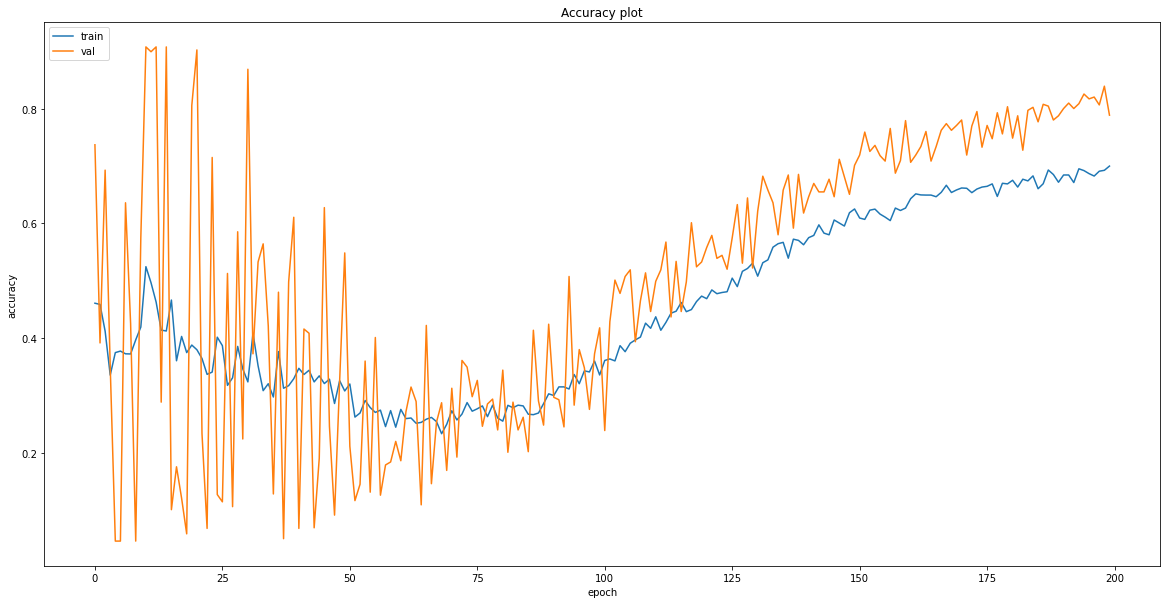

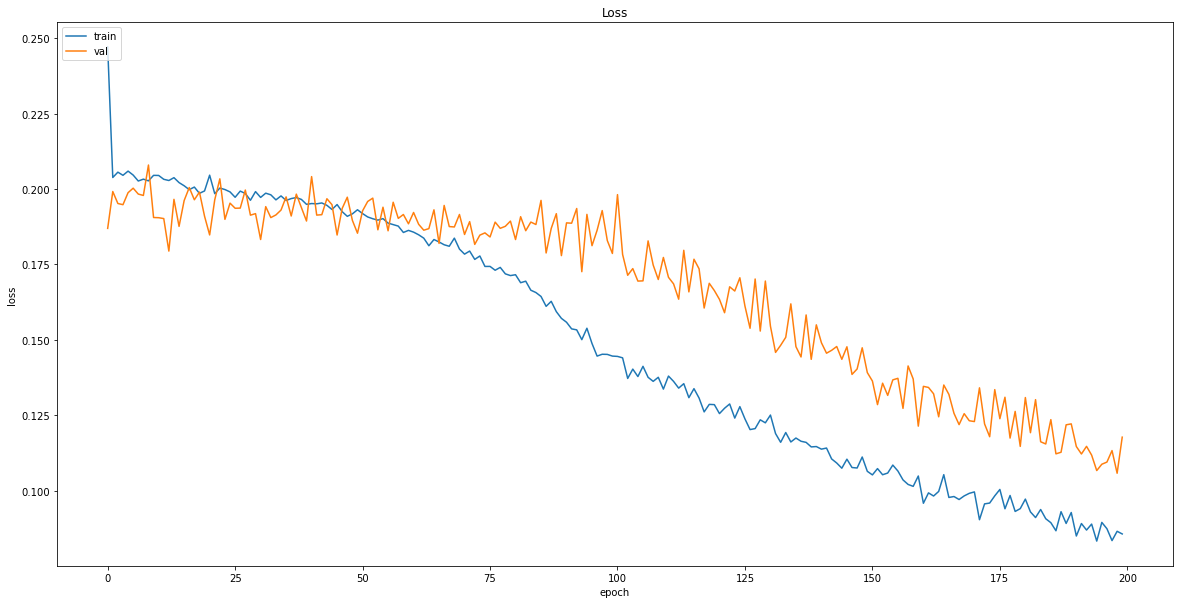

In [196]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [197]:
# Save model
model.save("models/{}".format('FDP_image_cnn_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/FDP_image_cnn_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [198]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,33.090000,32.210365,-29.500008,41799100.0,0.0
2018-12-14,33.310001,32.379540,-23.999977,42032900.0,2.0
2018-12-17,32.500000,32.398072,-44.923863,41904100.0,2.0
2018-12-18,32.150002,32.359908,-55.064902,41601100.0,2.0
2018-12-19,30.770000,32.115306,-94.085991,41369900.0,2.0


In [199]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [201]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [202]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [203]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1236 - accuracy: 0.7752 - mean_squared_error: 1.9702 - weighted_accuracy: 0.7752 - weighted_mean_squared_error: 1.9702
Test loss: 0.12358474731445312
Test accuracy: 0.7752293348312378


In [204]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 1: 17, 0: 18})

In [205]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [206]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-206-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-206-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-206-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,2,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,1,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,1,0


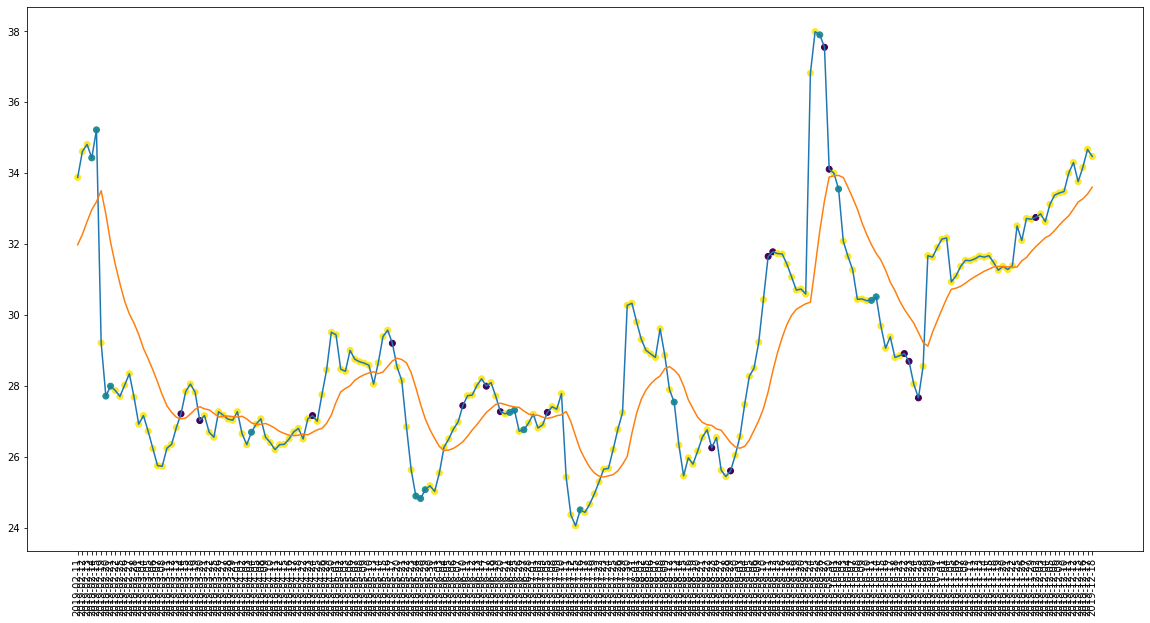

In [207]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

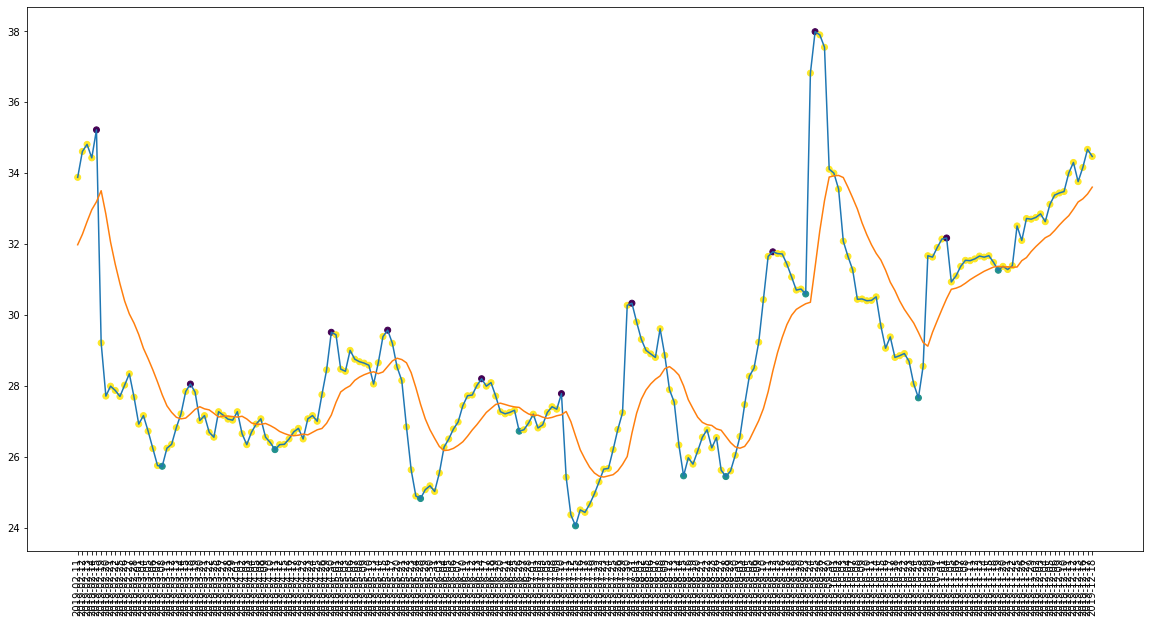

In [208]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [209]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 15
actual holds but predicted sell: 16
actual predicted holds: 167
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 84.34343434343434%
actual buys: 10
actual sells: 10
actual holds: 198


In [210]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 41.1764705882353%
Percentage sells correct: 61.111111111111114%
Percentage holds correct: 83.51648351648352%


In [211]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $34.43000030517578
Shares owned at the moment: 289
Cash capital at the moment: $22.366669061661014


Stop Loss Activated!

Share price: $29.209999084472656
Shares owned at the moment: 0
Cash capital at the moment: $8440.841757701874


Share price: $27.709999084472656
Shares owned at the moment: 303
Cash capital at the moment: $21.622678369521964


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8155.9516114230155


Share price: $26.690000534057607
Shares owned at the moment: 304
Cash capital at the moment: $19.87860862303114


Price increase from previously bought: 9.104235284991802%
Share price: $29.20000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8872.267639918806


Share price: $24.88999938964844
Shares owned at the moment: 355
Cash capital at the moment: $12.018994689464307


Price increase from previously bought: 9.942740657006777%
Share price: $27.440000534057607
Shares owned a

In [212]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [213]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-13,34.299999,33.185402,-7.909676,-4911100.0,2.0
2019-12-16,33.759998,33.273801,-23.163935,-5027000.0,2.0
2019-12-17,34.160000,33.410139,-15.789538,-4850100.0,2.0
2019-12-18,34.669998,33.603964,-3.968344,-4647200.0,2.0
2019-12-19,34.470001,33.737200,-18.420973,-4830200.0,2.0


In [214]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df2.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]
    
    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [215]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [216]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [217]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [218]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1104 - accuracy: 0.8037 - mean_squared_error: 2.0359 - weighted_accuracy: 0.8037 - weighted_mean_squared_error: 2.0359
Test loss: 0.11044766753911972
Test accuracy: 0.8036529421806335


In [219]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 188, 0: 15, 1: 16})

In [220]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [221]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-221-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-221-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-221-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,2,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,2,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,2,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,0,2


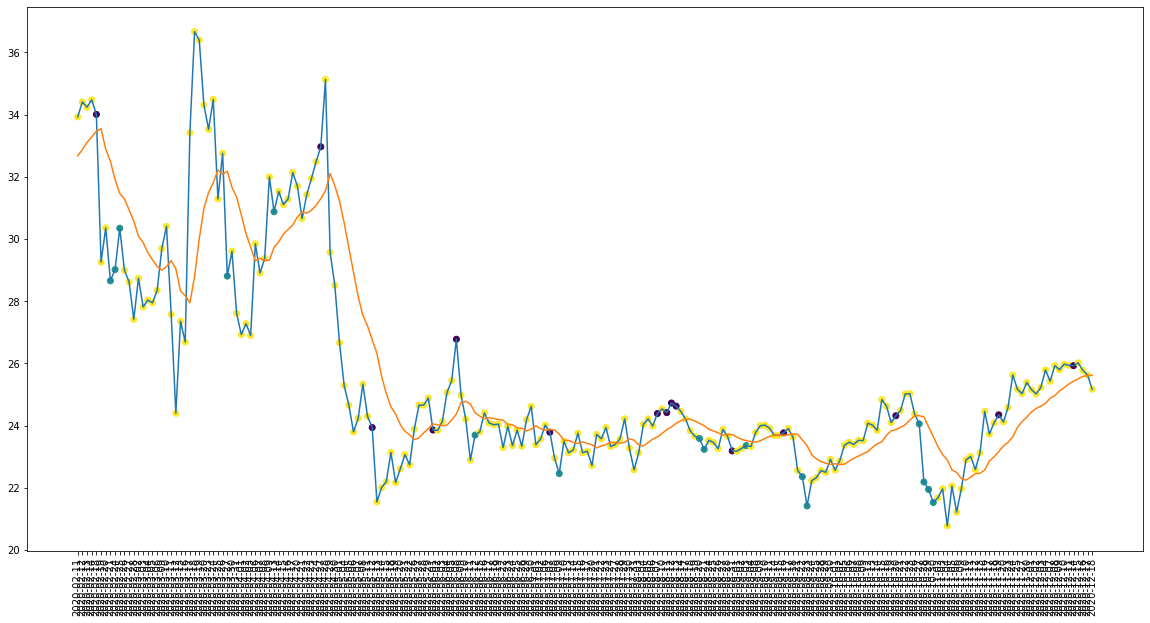

In [222]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

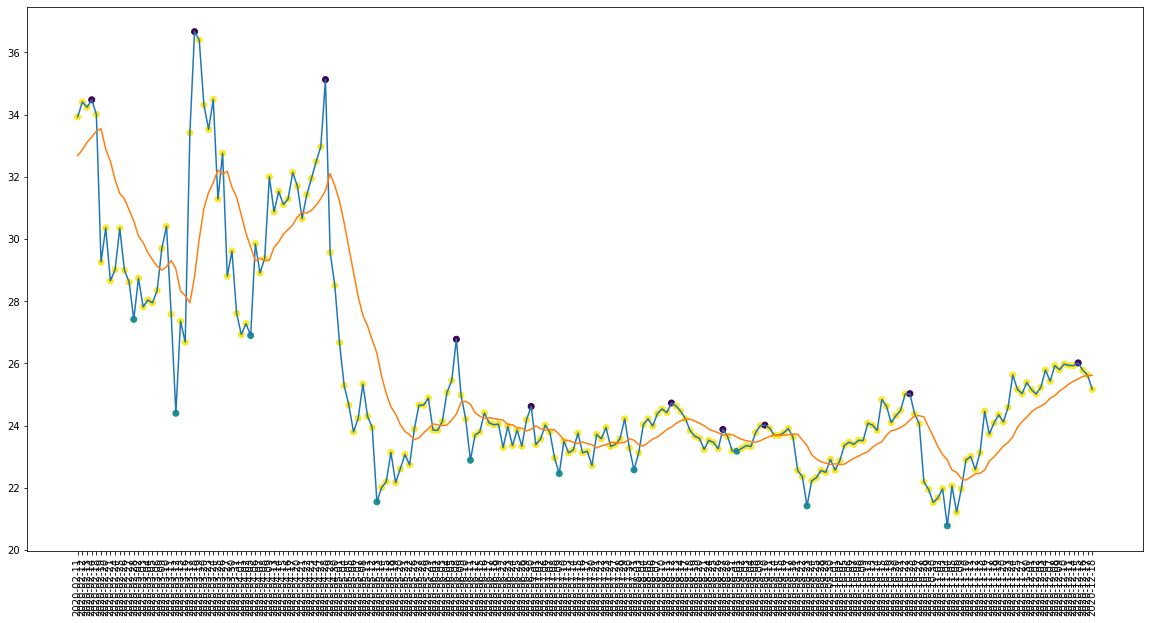

In [223]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [224]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 14
actual holds but predicted sell: 13
actual predicted holds: 172
Percentage buys correct: 20.0%
Percentage sells correct: 20.0%
Percentage holds correct: 86.4321608040201%
actual buys: 10
actual sells: 10
actual holds: 199


In [225]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 62.5%
Percentage sells correct: 60.0%
Percentage holds correct: 82.3529411764706%


In [226]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.65999984741211
Shares owned at the moment: 347
Cash capital at the moment: $27.63124809360488


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9516.2057394948


Share price: $28.809999465942386
Shares owned at the moment: 329
Cash capital at the moment: $11.650068182943869


Stop Loss Activated!

Share price: $27.61000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9070.36012093639


Share price: $30.8799991607666
Shares owned at the moment: 292
Cash capital at the moment: $28.603726666446164


Price increase from previously bought: 6.475334400143873%
Share price: $32.970001220703125
Shares owned at the moment: 0
Cash capital at the moment: $9629.369172131534


Share price: $23.70000076293945
Shares owned at the moment: 405
Cash capital at the moment: $4.472987291332174


Stop Loss Activated!

Share price: $22.959999084472656
Shares owned at the moment: 0
Cash capital at the moment:

In [227]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
